In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import pymc as pm
import pytensor.tensor as pt
import warnings
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# LANGUAGE PAIR DEFINITIONS
# =============================================================================

LANGUAGE_PAIRS = {
    'en_es': {'ui': 'en', 'learning': 'es', 'label': 'EN → ES'},
    'en_fr': {'ui': 'en', 'learning': 'fr', 'label': 'EN → FR'},
    'en_de': {'ui': 'en', 'learning': 'de', 'label': 'EN → DE'},
    'en_it': {'ui': 'en', 'learning': 'it', 'label': 'EN → IT'},
    'en_pt': {'ui': 'en', 'learning': 'pt', 'label': 'EN → PT'},
    'es_en': {'ui': 'es', 'learning': 'en', 'label': 'ES → EN'},
    'it_en': {'ui': 'it', 'learning': 'en', 'label': 'IT → EN'},
    'pt_en': {'ui': 'pt', 'learning': 'en', 'label': 'PT → EN'},
}

In [3]:
# =============================================================================
# STEP 0 — DATA LOADING & FILTERING
# =============================================================================

def load_and_filter(filepath, delta_min=100, delta_max=14*24*3600, min_reviews=50):
    """
    Load the Duolingo HLR dataset and apply delta filtering.

    Parameters
    ----------
    filepath     : path to settles.acl16.learning_traces.13m.csv
    delta_min    : minimum seconds since last review (default: 100s)
    delta_max    : maximum seconds since last review (default: 2 weeks)
    min_reviews  : minimum reviews per user to be included (default: 50)

    Returns
    -------
    df_filtered  : filtered DataFrame
    """
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    df = df[df['delta'] > 0].copy()

    df_filtered = df[(df['delta'] >= delta_min) & (df['delta'] <= delta_max)].copy()

    user_counts = df_filtered.groupby('user_id').size()
    eligible = user_counts[user_counts >= min_reviews].index
    df_filtered = df_filtered[df_filtered['user_id'].isin(eligible)]

    print(f"Original rows:  {len(df):,}")
    print(f"Filtered rows:  {len(df_filtered):,} ({100*len(df_filtered)/len(df):.1f}%)")
    print(f"Eligible users: {len(eligible):,}")

    if 'ui_language' in df_filtered.columns and 'learning_language' in df_filtered.columns:
        pair_counts = df_filtered.groupby(['ui_language', 'learning_language'])['user_id'].nunique()
        print("\nUsers per language pair:")
        print(pair_counts.to_string())

    return df_filtered

In [4]:
def filter_by_language_pair(df, ui_language, learning_language):
    """
    Filter dataset to a specific language pair.

    Parameters
    ----------
    df               : full filtered DataFrame from load_and_filter()
    ui_language      : interface language code (e.g. 'en')
    learning_language: target language code (e.g. 'es')

    Returns
    -------
    Filtered DataFrame for the given language pair
    """
    mask = (df['ui_language'] == ui_language) & (df['learning_language'] == learning_language)
    subset = df[mask].copy()
    print(f"Language pair {ui_language} → {learning_language}: "
          f"{len(subset):,} rows, {subset['user_id'].nunique():,} users")
    return subset

In [5]:
# =============================================================================
# STEP 1 — DESCRIPTIVE FORGETTING CURVES
# =============================================================================

def plot_forgetting_curves(df, n_users=50, min_reviews=200, title_suffix='', ax=None):
    """
    Plot individual learner forgetting curves vs. population average.

    Parameters
    ----------
    df           : filtered DataFrame
    n_users      : number of individual users to overlay
    min_reviews  : minimum reviews for a user to be eligible for overlay
    title_suffix : string appended to plot title (e.g. language pair label)
    ax           : optional matplotlib axis; creates new figure if None
    """
    df = df.copy()
    df['log_delta'] = np.log10(df['delta'])
    df['delta_bin'] = pd.cut(df['log_delta'], bins=20)

    pop_curve = df.groupby('delta_bin', observed=True)['p_recall'].mean().reset_index()
    pop_curve['bin_mid'] = pop_curve['delta_bin'].apply(lambda x: x.mid)

    user_counts = df.groupby('user_id').size()
    eligible = user_counts[user_counts >= min_reviews].index
    if len(eligible) == 0:
        print("Not enough users with sufficient reviews for overlay.")
        return
    sampled = np.random.choice(eligible, size=min(n_users, len(eligible)), replace=False)

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    for user in sampled:
        udf = df[df['user_id'] == user]
        curve = udf.groupby('delta_bin', observed=True)['p_recall'].mean().reset_index()
        curve['bin_mid'] = curve['delta_bin'].apply(lambda x: x.mid)
        ax.plot(curve['bin_mid'], curve['p_recall'], color='steelblue', alpha=0.15, linewidth=1)

    ax.plot(pop_curve['bin_mid'], pop_curve['p_recall'],
            color='red', linewidth=2.5, label='Population average')
    ax.set_xlabel('log10(seconds since last review)')
    ax.set_ylabel('Average p_recall')
    ax.set_title(f'Forgetting Curves: Individual vs. Population {title_suffix}')
    ax.legend()

    return ax

In [6]:
# =============================================================================
# STEP 2 — NAIVE PER-LEARNER HALF-LIFE FITTING
# =============================================================================

def _forgetting_curve(t, h):
    return np.exp(-t / h)


def fit_naive_halflife(df, initial_guess=86400):
    """
    Fit exponential forgetting curve p = exp(-t/h) independently per learner.

    Parameters
    ----------
    df           : filtered DataFrame
    initial_guess: initial half-life guess in seconds (default: 1 day)

    Returns
    -------
    results_df   : DataFrame with columns [user_id, half_life, half_life_days,
                   n_reviews, mean_p_recall]
    """
    print("Fitting per-learner half-life...")
    results = []

    for user_id, udf in df.groupby('user_id'):
        t = udf['delta'].values
        p = udf['p_recall'].values
        try:
            popt, _ = curve_fit(_forgetting_curve, t, p,
                                p0=[initial_guess], bounds=(1, np.inf))
            results.append({
                'user_id': user_id,
                'half_life': popt[0],
                'half_life_days': popt[0] / 86400,
                'n_reviews': len(udf),
                'mean_p_recall': p.mean()
            })
        except RuntimeError:
            pass

    results_df = pd.DataFrame(results)
    print(f"Successfully fit: {len(results_df):,} users")
    print(f"\nHalf-life summary (days):")
    print(results_df['half_life_days'].describe().round(1))
    return results_df

In [7]:
def plot_halflife_distribution(results_df, title_suffix='', ax=None):
    """
    Plot distribution of per-learner half-lives and half-life vs. mean recall.

    Parameters
    ----------
    results_df   : output of fit_naive_halflife()
    title_suffix : string appended to plot titles
    ax           : optional list of 2 axes; creates new figure if None
    """
    if ax is None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    else:
        axes = ax

    # Left: distribution
    axes[0].hist(np.log10(results_df['half_life_days']), bins=80,
                 color='steelblue', edgecolor='white')
    axes[0].set_xlabel('log10(half-life in days)')
    axes[0].set_ylabel('Number of users')
    axes[0].set_title(f'Half-Life Distribution {title_suffix}')
    for val, label in [(1, '10d'), (1.7, '50d'), (2, '100d')]:
        axes[0].axvline(val, color='red', linestyle='--', alpha=0.5)
        axes[0].text(val+0.03, axes[0].get_ylim()[1]*0.85, label, color='red', fontsize=8)

    # Right: half-life vs recall
    axes[1].scatter(np.log10(results_df['half_life_days']),
                    results_df['mean_p_recall'], alpha=0.05, s=5, color='steelblue')
    r, pval = spearmanr(np.log10(results_df['half_life_days']), results_df['mean_p_recall'])
    axes[1].set_xlabel('log10(half-life in days)')
    axes[1].set_ylabel('Mean p_recall')
    axes[1].set_title(f'Half-Life vs. Recall {title_suffix}')
    axes[1].text(0.05, 0.95, f'r = {r:.3f}, p = {pval:.2e}',
                 transform=axes[1].transAxes, fontsize=10, verticalalignment='top')

    plt.tight_layout()
    return axes

In [8]:
# =============================================================================
# STEP 3 — BAYESIAN HIERARCHICAL MODEL (PyMC)
# =============================================================================

def sample_users_stratified(results_df, df_filtered, n_per_quintile=100, random_state=42):
    """
    Stratified sample of users across half-life quintiles.

    Parameters
    ----------
    results_df    : output of fit_naive_halflife()
    df_filtered   : filtered DataFrame from load_and_filter()
    n_per_quintile: users to sample per quintile (default: 100)
    random_state  : random seed

    Returns
    -------
    df_model      : filtered DataFrame for sampled users
    user_codes    : array of user_id values (index → user_id mapping)
    user_idx      : integer index array aligned with df_model rows
    """
    results_df = results_df.copy()
    results_df['hl_quintile'] = pd.qcut(results_df['half_life_days'], q=5, labels=False)

    sampled_users = (
        results_df.groupby('hl_quintile')
        .apply(lambda x: x.sample(min(n_per_quintile, len(x)), random_state=random_state))
        .reset_index(drop=True)
    )['user_id'].values

    df_model = df_filtered[df_filtered['user_id'].isin(sampled_users)].copy()
    df_model['delta_days'] = df_model['delta'] / 86400
    user_idx, user_codes = pd.factorize(df_model['user_id'])
    df_model['user_idx'] = user_idx

    print(f"Sampled {len(sampled_users)} users, {len(df_model):,} rows")
    return df_model, user_codes, user_idx

In [9]:
def fit_hierarchical_model(df_model, user_codes, user_idx,
                            draws=1000, tune=1000, chains=4,
                            target_accept=0.9, random_seed=42):
    """
    Fit Bayesian hierarchical forgetting model with PyMC.

    Model: p_recall ~ Normal(exp(-delta / exp(mu + sigma * z_i)), sigma_obs)
    where z_i ~ Normal(0,1) per learner (non-centered parameterization)

    Parameters
    ----------
    df_model     : output of sample_users_stratified()
    user_codes   : user_id mapping array
    user_idx     : integer index array
    draws        : MCMC draws per chain
    tune         : tuning steps per chain
    chains       : number of chains
    target_accept: NUTS target acceptance rate
    random_seed  : random seed

    Returns
    -------
    trace        : ArviZ InferenceData object
    """
    n_users = len(user_codes)
    t = df_model['delta_days'].values
    p = df_model['p_recall'].values

    with pm.Model() as forgetting_model:
        mu_log_h    = pm.Normal('mu_log_h', mu=3.7, sigma=1.0)
        sigma_log_h = pm.HalfNormal('sigma_log_h', sigma=1.0)
        z           = pm.Normal('z', mu=0, sigma=1, shape=n_users)
        log_h_i     = pm.Deterministic('log_h_i', mu_log_h + sigma_log_h * z)
        h_i         = pm.Deterministic('h_i', pt.exp(log_h_i))
        p_pred      = pt.exp(-t / h_i[user_idx])
        sigma_obs   = pm.HalfNormal('sigma_obs', sigma=0.1)
        _           = pm.Normal('likelihood', mu=p_pred, sigma=sigma_obs, observed=p)

        trace = pm.sample(draws, tune=tune, chains=chains,
                          target_accept=target_accept,
                          random_seed=random_seed, progressbar=True)

    print(pm.summary(trace, var_names=['mu_log_h', 'sigma_log_h', 'sigma_obs']))
    return trace

In [10]:
# =============================================================================
# STEP 4 — SHRINKAGE & POSTERIOR VISUALIZATION
# =============================================================================

def build_hierarchical_df(trace, df_model, user_codes, results_naive):
    """
    Build a per-learner DataFrame combining hierarchical posteriors and naive estimates.

    Parameters
    ----------
    trace        : output of fit_hierarchical_model()
    df_model     : output of sample_users_stratified()
    user_codes   : user_id mapping array
    results_naive: output of fit_naive_halflife()

    Returns
    -------
    hierarchical_df : DataFrame with posterior means, HDIs, naive estimates
    """
    log_h_samples  = trace.posterior['log_h_i'].values.reshape(-1, len(user_codes))
    h_samples_days = np.exp(log_h_samples)

    h_posterior_mean = h_samples_days.mean(axis=0)
    h_hdi_low  = np.percentile(h_samples_days, 3, axis=0)
    h_hdi_high = np.percentile(h_samples_days, 97, axis=0)

    naive_lookup = results_naive.set_index('user_id')['half_life_days']

    hierarchical_df = pd.DataFrame({
        'user_id':        user_codes,
        'h_hierarchical': h_posterior_mean,
        'h_hdi_low':      h_hdi_low,
        'h_hdi_high':     h_hdi_high,
        'n_reviews':      df_model.groupby('user_idx').size().values
    })
    hierarchical_df['h_naive'] = hierarchical_df['user_id'].map(naive_lookup)
    hierarchical_df['log_h']   = np.log10(hierarchical_df['h_hierarchical'])

    return hierarchical_df

In [11]:
def plot_hierarchical_results(trace, hierarchical_df, title_suffix=''):
    """
    Plot posterior of population parameters, shrinkage, and uncertainty vs. data quantity.

    Parameters
    ----------
    trace           : output of fit_hierarchical_model()
    hierarchical_df : output of build_hierarchical_df()
    title_suffix    : string appended to plot titles
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Left: population mean half-life posterior
    mu_samples = trace.posterior['mu_log_h'].values.flatten()
    axes[0].hist(np.exp(mu_samples), bins=60, color='steelblue', edgecolor='white', alpha=0.8)
    axes[0].axvline(np.exp(mu_samples.mean()), color='red', linewidth=2,
                    label=f'Mean: {np.exp(mu_samples.mean()):.1f} days')
    axes[0].set_xlabel('Half-life (days)')
    axes[0].set_title(f'Population Mean Half-Life {title_suffix}')
    axes[0].legend()

    # Middle: shrinkage plot
    axes[1].scatter(np.log10(hierarchical_df['h_naive']),
                    np.log10(hierarchical_df['h_hierarchical']),
                    alpha=0.3, s=8, color='steelblue')
    lims = [min(np.log10(hierarchical_df[['h_naive', 'h_hierarchical']]).min()),
            max(np.log10(hierarchical_df[['h_naive', 'h_hierarchical']]).max())]
    axes[1].plot(lims, lims, 'r--', linewidth=1.5, label='No shrinkage')
    axes[1].set_xlabel('log10(naive half-life) — Step 2')
    axes[1].set_ylabel('log10(hierarchical half-life) — Step 3')
    axes[1].set_title(f'Shrinkage Effect {title_suffix}')
    axes[1].legend()

    shrinkage_ratio = (np.log10(hierarchical_df['h_hierarchical']).std() /
                       np.log10(hierarchical_df['h_naive']).std())
    print(f"Shrinkage ratio: {shrinkage_ratio:.3f}")

    # Right: uncertainty vs. data quantity
    hierarchical_df['hdi_width'] = (np.log10(hierarchical_df['h_hdi_high']) -
                                    np.log10(hierarchical_df['h_hdi_low']))
    axes[2].scatter(np.log10(hierarchical_df['n_reviews']),
                    hierarchical_df['hdi_width'],
                    alpha=0.3, s=8, color='steelblue')
    axes[2].set_xlabel('log10(number of reviews)')
    axes[2].set_ylabel('HDI width (log10 days)')
    axes[2].set_title(f'Uncertainty vs. Data Quantity {title_suffix}')

    plt.suptitle(f'Hierarchical Model Results {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

In [12]:
# =============================================================================
# STEP 5 — FEATURE ENGINEERING & REGRESSION
# =============================================================================

def engineer_features(df_filtered, hierarchical_df):
    """
    Engineer per-learner behavioral and performance features and merge with half-life.

    Parameters
    ----------
    df_filtered     : filtered DataFrame (for the sampled users)
    hierarchical_df : output of build_hierarchical_df()

    Returns
    -------
    features_df : DataFrame with engineered features and log_h target
    """
    sampled_users = hierarchical_df['user_id'].values
    features = []

    for user_id, udf in df_filtered[df_filtered['user_id'].isin(sampled_users)].groupby('user_id'):
        features.append({
            'user_id':          user_id,
            'n_reviews':        len(udf),
            'n_lexemes':        udf['lexeme_id'].nunique(),
            'mean_accuracy':    (udf['history_correct'] / udf['history_seen'].clip(lower=1)).mean(),
            'mean_delta_days':  udf['delta'].mean() / 86400,
            'median_delta_days':udf['delta'].median() / 86400,
            'cv_delta':         udf['delta'].std() / udf['delta'].mean()
                                if udf['delta'].mean() > 0 else np.nan,
            'mean_history_seen':udf['history_seen'].mean(),
        })

    features_df = pd.DataFrame(features)
    features_df = features_df.merge(hierarchical_df[['user_id', 'h_hierarchical']], on='user_id')
    features_df['log_h'] = np.log10(features_df['h_hierarchical'])

    # Log-transform skewed features
    features_df['log_n_reviews']    = np.log10(features_df['n_reviews'])
    features_df['log_n_lexemes']    = np.log10(features_df['n_lexemes'])
    features_df['log_mean_delta']   = np.log10(features_df['mean_delta_days'].clip(lower=0.01))
    features_df['log_cv_delta']     = np.log10(features_df['cv_delta'].clip(lower=0.01))
    features_df['log_history_seen'] = np.log10(features_df['mean_history_seen'])

    return features_df

In [13]:
def run_regression_analysis(features_df, title_suffix=''):
    """
    Run three OLS regression models (behavioral, performance, full) and plot partial regressions.

    Parameters
    ----------
    features_df  : output of engineer_features()
    title_suffix : string appended to plot titles

    Returns
    -------
    results_dict : dict with keys 'behavioral', 'performance', 'full' → statsmodels results
    corr_df      : Spearman correlation table
    """
    feature_sets = {
        'Behavioral':  ['log_n_reviews', 'log_n_lexemes', 'log_cv_delta', 'log_history_seen'],
        'Performance': ['mean_accuracy', 'log_mean_delta'],
        'Full':        ['log_n_reviews', 'log_n_lexemes', 'log_cv_delta',
                        'log_history_seen', 'mean_accuracy', 'log_mean_delta']
    }
    feature_labels = {
        'log_n_reviews':    'Practice Volume (log)',
        'log_n_lexemes':    'Vocabulary Breadth (log)',
        'log_cv_delta':     'Spacing Irregularity (log CV)',
        'log_history_seen': 'Avg Repetitions/Word (log)',
        'mean_accuracy':    'Mean Accuracy',
        'log_mean_delta':   'Avg Review Gap (log days)'
    }

    y = features_df['log_h'].values
    results_dict = {}

    print("=" * 65)
    for model_name, feats in feature_sets.items():
        X = np.nan_to_num(features_df[feats].values)
        X_scaled = StandardScaler().fit_transform(X)
        X_sm = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_sm).fit()
        cv_r2 = cross_val_score(LinearRegression(), X_scaled, y, cv=5, scoring='r2').mean()
        results_dict[model_name] = model

        print(f"\n--- {model_name} Model {title_suffix} ---")
        print(f"R²: {model.rsquared:.3f}  Adj R²: {model.rsquared_adj:.3f}  CV R²: {cv_r2:.3f}")
        print(f"{'Feature':<35} {'Coef':>7} {'p':>7}")
        print("-" * 55)
        for name, coef, p in zip(['intercept']+feats, model.params, model.pvalues):
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{name:<35} {coef:>7.3f} {p:>7.3f} {sig}")
    print("=" * 65)

    # Spearman correlations
    full_feats = feature_sets['Full']
    corr_results = []
    for feat in full_feats:
        r, p = spearmanr(features_df[feat], features_df['log_h'])
        corr_results.append({'feature': feature_labels[feat], 'r': r, 'p': p})
    corr_df = pd.DataFrame(corr_results).sort_values('r', key=abs, ascending=False)

    # Partial regression plots
    X_full_scaled = StandardScaler().fit_transform(
        np.nan_to_num(features_df[full_feats].values))
    X_full_df = pd.DataFrame(X_full_scaled, columns=full_feats)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()

    for i, feat in enumerate(full_feats):
        ax = axes[i]
        others = [f for f in full_feats if f != feat]
        X_other = sm.add_constant(X_full_df[others].values)
        resid_y = sm.OLS(y, X_other).fit().resid
        resid_x = sm.OLS(X_full_df[feat].values, X_other).fit().resid

        ax.scatter(resid_x, resid_y, alpha=0.3, s=12, color='steelblue')
        m, b = np.polyfit(resid_x, resid_y, 1)
        x_line = np.linspace(resid_x.min(), resid_x.max(), 100)
        ax.plot(x_line, m*x_line+b, color='red', linewidth=2)

        r, p = spearmanr(resid_x, resid_y)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'
        ax.set_xlabel(f'e({feature_labels[feat]} | others)')
        ax.set_ylabel('e(log half-life | others)')
        ax.set_title(f'Partial r = {r:.3f} {sig}')
        ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')
        ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

    plt.suptitle(f'Partial Regression Plots {title_suffix}', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    return results_dict, corr_df

In [14]:
# =============================================================================
# LANGUAGE PAIR COMPARISON
# =============================================================================

def compare_language_pairs(df, pairs_to_compare, results_naive_full=None):
    """
    Compare half-life distributions across language pairs using naive estimates.

    Parameters
    ----------
    df                : full filtered DataFrame from load_and_filter()
    pairs_to_compare  : list of keys from LANGUAGE_PAIRS dict
                        e.g. ['en_es', 'en_fr', 'es_en']
    results_naive_full: optional pre-computed naive results for all users

    Returns
    -------
    comparison_df : DataFrame with per-user half-life and language pair label
    """
    all_results = []

    for pair_key in pairs_to_compare:
        pair_info = LANGUAGE_PAIRS[pair_key]
        subset = filter_by_language_pair(df, pair_info['ui'], pair_info['learning'])

        if len(subset) == 0:
            print(f"  No data for {pair_info['label']}, skipping.")
            continue

        naive = fit_naive_halflife(subset)
        naive['pair'] = pair_info['label']
        all_results.append(naive)

    comparison_df = pd.concat(all_results, ignore_index=True)

    # Plot distributions per language pair
    pairs = comparison_df['pair'].unique()
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Left: overlapping KDE-style histograms
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
    for pair, color in zip(pairs, colors):
        data = np.log10(comparison_df[comparison_df['pair'] == pair]['half_life_days'])
        axes[0].hist(data, bins=50, alpha=0.4, label=pair, color=color, density=True)
    axes[0].set_xlabel('log10(half-life in days)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Half-Life Distribution by Language Pair')
    axes[0].legend()

    # Right: boxplot comparison
    pair_data = [np.log10(comparison_df[comparison_df['pair'] == p]['half_life_days'])
                 for p in pairs]
    bp = axes[1].boxplot(pair_data, labels=pairs, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    axes[1].set_ylabel('log10(half-life in days)')
    axes[1].set_title('Half-Life Comparison by Language Pair')
    axes[1].tick_params(axis='x', rotation=30)

    plt.tight_layout()
    plt.show()

    # Summary stats
    print("\nSummary statistics by language pair:")
    summary = comparison_df.groupby('pair')['half_life_days'].agg(
        ['median', 'mean', 'std', 'count']).round(1)
    print(summary)

    return comparison_df

In [15]:
# =============================================================================
# FULL PIPELINE — single language pair
# =============================================================================

def run_full_pipeline(df, ui_language, learning_language,
                      n_per_quintile=100, pymc_draws=1000, pymc_tune=1000,
                      pymc_chains=4, random_seed=42):
    """
    Run the complete forgetting rate analysis pipeline for one language pair.

    Steps:
        1. Filter to language pair
        2. Plot forgetting curves
        3. Fit naive half-life per learner
        4. Plot half-life distribution
        5. Stratified sample + fit hierarchical model
        6. Build hierarchical estimates + shrinkage plot
        7. Engineer features + regression analysis

    Parameters
    ----------
    df               : full filtered DataFrame from load_and_filter()
    ui_language      : interface language code
    learning_language: target language code
    n_per_quintile   : users per quintile for hierarchical model
    pymc_draws/tune/chains: PyMC sampling parameters
    random_seed      : random seed

    Returns
    -------
    dict with keys: subset, results_naive, trace, hierarchical_df, features_df,
                    regression_results, corr_df
    """
    pair_label = f"({ui_language} → {learning_language})"
    print(f"\n{'='*60}")
    print(f"Running full pipeline for {pair_label}")
    print(f"{'='*60}\n")

    # Step 1: filter to language pair
    subset = filter_by_language_pair(df, ui_language, learning_language)

    # Step 2: forgetting curves
    print("\n--- Step 1: Forgetting Curves ---")
    plot_forgetting_curves(subset, title_suffix=pair_label)
    plt.show()

    # Step 3: naive half-life
    print("\n--- Step 2: Naive Half-Life Fitting ---")
    results_naive = fit_naive_halflife(subset)
    plot_halflife_distribution(results_naive, title_suffix=pair_label)
    plt.show()

    # Step 4: hierarchical model
    print("\n--- Step 3: Hierarchical Model ---")
    df_model, user_codes, user_idx = sample_users_stratified(
        results_naive, subset, n_per_quintile=n_per_quintile, random_state=random_seed)
    trace = fit_hierarchical_model(
        df_model, user_codes, user_idx,
        draws=pymc_draws, tune=pymc_tune, chains=pymc_chains, random_seed=random_seed)

    # Step 5: shrinkage plots
    print("\n--- Step 4: Shrinkage & Posterior Visualization ---")
    hierarchical_df = build_hierarchical_df(trace, df_model, user_codes, results_naive)
    plot_hierarchical_results(trace, hierarchical_df, title_suffix=pair_label)

    # Step 6: regression
    print("\n--- Step 5: Feature Engineering & Regression ---")
    features_df = engineer_features(subset, hierarchical_df)
    regression_results, corr_df = run_regression_analysis(features_df, title_suffix=pair_label)

    print(f"\nDone! {pair_label}")

    return {
        'subset':               subset,
        'results_naive':        results_naive,
        'trace':                trace,
        'hierarchical_df':      hierarchical_df,
        'features_df':          features_df,
        'regression_results':   regression_results,
        'corr_df':              corr_df
    }

In [16]:
# =============================================================================
# DIRECTION B — WORD-LEVEL EFFECTS
# =============================================================================
def estimate_lexeme_difficulty(df_filtered):
    """
    Estimate per-lexeme difficulty as the average p_recall across all learners.
    Lower mean p_recall = harder lexeme.
    Also fit a naive half-life per lexeme.

    Parameters
    ----------
    df_filtered : filtered DataFrame from load_and_filter()

    Returns
    -------
    lexeme_df : DataFrame with columns [lexeme_id, mean_p_recall, n_observations,
                half_life_days] sorted by difficulty (hardest first)
    """
    print("Estimating lexeme difficulty...")

    # Mean p_recall per lexeme (simple difficulty proxy)
    lexeme_stats = df_filtered.groupby('lexeme_id').agg(
        mean_p_recall  = ('p_recall', 'mean'),
        n_observations = ('p_recall', 'count'),
        mean_delta     = ('delta', 'mean')
    ).reset_index()

    # Only keep lexemes with enough observations for reliable estimates
    lexeme_stats = lexeme_stats[lexeme_stats['n_observations'] >= 30]

    # Fit half-life per lexeme
    print(f"Fitting half-life for {len(lexeme_stats):,} lexemes...")
    hl_results = []
    for lex_id, ldf in df_filtered[
            df_filtered['lexeme_id'].isin(lexeme_stats['lexeme_id'])
        ].groupby('lexeme_id'):
        if len(ldf) < 30:
            continue
        try:
            popt, _ = curve_fit(_forgetting_curve, ldf['delta'].values,
                                ldf['p_recall'].values,
                                p0=[86400], bounds=(1, np.inf))
            hl_results.append({'lexeme_id': lex_id, 'lex_half_life_days': popt[0]/86400})
        except RuntimeError:
            pass

    hl_df = pd.DataFrame(hl_results)
    lexeme_df = lexeme_stats.merge(hl_df, on='lexeme_id', how='left')
    lexeme_df = lexeme_df.sort_values('mean_p_recall')

    print(f"\nLexeme difficulty summary:")
    print(f"Total lexemes with >= 30 obs: {len(lexeme_df):,}")
    print(f"\nHardest 10 lexemes (lowest mean p_recall):")
    print(lexeme_df.head(10)[['lexeme_id', 'mean_p_recall', 'n_observations',
                               'lex_half_life_days']].to_string(index=False))
    print(f"\nEasiest 10 lexemes (highest mean p_recall):")
    print(lexeme_df.tail(10)[['lexeme_id', 'mean_p_recall', 'n_observations',
                               'lex_half_life_days']].to_string(index=False))

    return lexeme_df

In [17]:
def add_lexeme_difficulty_to_features(features_df, df_filtered, lexeme_df):
    """
    Add per-learner average lexeme difficulty to the features DataFrame.

    For each learner, compute:
    - mean_lex_difficulty: average mean_p_recall of lexemes they studied
      (lower = assigned harder words)
    - std_lex_difficulty: spread of difficulty across their lexemes
    - mean_lex_halflife: average half-life of their assigned lexemes

    Parameters
    ----------
    features_df  : output of engineer_features()
    df_filtered  : filtered DataFrame
    lexeme_df    : output of estimate_lexeme_difficulty()

    Returns
    -------
    features_enriched : features_df with additional lexeme columns
    """
    lex_lookup = lexeme_df.set_index('lexeme_id')[['mean_p_recall', 'lex_half_life_days']]
    enriched = []

    sampled_users = features_df['user_id'].values

    for user_id, udf in df_filtered[
            df_filtered['user_id'].isin(sampled_users)
        ].groupby('user_id'):

        user_lexemes = udf['lexeme_id'].unique()
        lex_data = lex_lookup.reindex(user_lexemes).dropna()

        if len(lex_data) == 0:
            continue

        enriched.append({
            'user_id':            user_id,
            'mean_lex_difficulty': lex_data['mean_p_recall'].mean(),
            'std_lex_difficulty':  lex_data['mean_p_recall'].std(),
            'mean_lex_halflife':   lex_data['lex_half_life_days'].mean()
        })

    enriched_df = pd.DataFrame(enriched)
    features_enriched = features_df.merge(enriched_df, on='user_id', how='left')

    # Log transform
    features_enriched['log_mean_lex_halflife'] = np.log10(
        features_enriched['mean_lex_halflife'].clip(lower=0.01))

    print(f"Added lexeme features to {len(features_enriched):,} learners")
    print(features_enriched[['mean_lex_difficulty', 'std_lex_difficulty',
                              'mean_lex_halflife']].describe().round(3))
    return features_enriched

In [18]:
def run_enriched_regression(features_enriched, title_suffix=''):
    """
    Rerun regression with lexeme difficulty added as a covariate.
    Compares full model without vs. with lexeme features.

    Parameters
    ----------
    features_enriched : output of add_lexeme_difficulty_to_features()
    title_suffix      : string appended to plot titles
    """
    y = features_enriched['log_h'].values

    base_feats     = ['log_n_reviews', 'log_n_lexemes', 'log_cv_delta',
                      'log_history_seen', 'mean_accuracy', 'log_mean_delta']
    enriched_feats = base_feats + ['mean_lex_difficulty', 'log_mean_lex_halflife']

    feature_labels = {
        'log_n_reviews':         'Practice Volume (log)',
        'log_n_lexemes':         'Vocabulary Breadth (log)',
        'log_cv_delta':          'Spacing Irregularity (log CV)',
        'log_history_seen':      'Avg Repetitions/Word (log)',
        'mean_accuracy':         'Mean Accuracy',
        'log_mean_delta':        'Avg Review Gap (log days)',
        'mean_lex_difficulty':   'Avg Lexeme Difficulty',
        'log_mean_lex_halflife': 'Avg Lexeme Half-Life (log)'
    }

    print("=" * 65)
    for model_name, feats in [('Full (no lexeme)', base_feats),
                               ('Full + Lexeme Difficulty', enriched_feats)]:
        X = np.nan_to_num(features_enriched[feats].values)
        X_scaled = StandardScaler().fit_transform(X)
        X_sm = sm.add_constant(X_scaled)
        model = sm.OLS(y, X_sm).fit()
        cv_r2 = cross_val_score(LinearRegression(), X_scaled, y,
                                cv=5, scoring='r2').mean()

        print(f"\n--- {model_name} {title_suffix} ---")
        print(f"R²: {model.rsquared:.3f}  Adj R²: {model.rsquared_adj:.3f}  CV R²: {cv_r2:.3f}")
        print(f"{'Feature':<40} {'Coef':>7} {'p':>7}")
        print("-" * 60)
        for name, coef, p in zip(['intercept']+feats, model.params, model.pvalues):
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{feature_labels.get(name, name):<40} {coef:>7.3f} {p:>7.3f} {sig}")
    print("=" * 65)

    # Visualize: learner half-life vs lexeme difficulty
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].scatter(features_enriched['mean_lex_difficulty'],
                    features_enriched['log_h'],
                    alpha=0.3, s=10, color='steelblue')
    r, p = spearmanr(features_enriched['mean_lex_difficulty'].dropna(),
                     features_enriched.loc[
                         features_enriched['mean_lex_difficulty'].notna(), 'log_h'])
    axes[0].set_xlabel('Mean Lexeme Difficulty (avg p_recall of assigned words)')
    axes[0].set_ylabel('log10(learner half-life, days)')
    axes[0].set_title(f'Learner Half-Life vs. Assigned Word Difficulty\nr = {r:.3f}, p = {p:.3f}')

    axes[1].scatter(features_enriched['log_mean_lex_halflife'],
                    features_enriched['log_h'],
                    alpha=0.3, s=10, color='steelblue')
    r2, p2 = spearmanr(features_enriched['log_mean_lex_halflife'].dropna(),
                       features_enriched.loc[
                           features_enriched['log_mean_lex_halflife'].notna(), 'log_h'])
    axes[1].set_xlabel('Avg Lexeme Half-Life (log days)')
    axes[1].set_ylabel('log10(learner half-life, days)')
    axes[1].set_title(f'Learner Half-Life vs. Lexeme Half-Life\nr = {r2:.3f}, p = {p2:.3f}')

    plt.suptitle(f'Lexeme Difficulty vs. Learner Forgetting Rate {title_suffix}',
                 fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

In [19]:
# =============================================================================
# DIRECTION C — LEARNER CLUSTERING
# =============================================================================

In [20]:
def prepare_clustering_features(features_enriched):
    """
    Select and scale features for clustering.
    We use the two dominant predictors + half-life itself,
    plus practice volume as a behavioral dimension.
    """
    cluster_feats = [
        'log_h',             # forgetting rate (our main variable)
        'mean_accuracy',     # performance
        'log_mean_delta',    # spacing behavior
        'log_n_reviews',     # effort/volume
        'log_cv_delta',      # consistency
    ]

    X_cluster = features_enriched[cluster_feats].copy()
    X_cluster = X_cluster.dropna()
    valid_idx = X_cluster.index

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    print(f"Clustering on {len(X_scaled)} learners with features: {cluster_feats}")
    return X_scaled, valid_idx, cluster_feats, scaler

In [21]:
def find_optimal_clusters(X_scaled, max_k=8):
    """
    Use elbow method (inertia) + silhouette scores + BIC (GMM)
    to find the optimal number of clusters.
    """
    ks = range(2, max_k + 1)
    inertias, silhouettes, bics = [], [], []

    for k in ks:
        # KMeans
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = km.fit_predict(X_scaled)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X_scaled, labels))

        # GMM BIC
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
        gmm.fit(X_scaled)
        bics.append(gmm.bic(X_scaled))

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    axes[0].plot(ks, inertias, 'o-', color='steelblue')
    axes[0].set_xlabel('Number of clusters k')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')

    axes[1].plot(ks, silhouettes, 'o-', color='steelblue')
    axes[1].axhline(max(silhouettes), color='red', linestyle='--', alpha=0.5)
    axes[1].set_xlabel('Number of clusters k')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score (higher = better)')
    best_k_sil = ks[np.argmax(silhouettes)]
    axes[1].axvline(best_k_sil, color='red', linestyle='--', alpha=0.5,
                    label=f'Best k={best_k_sil}')
    axes[1].legend()

    axes[2].plot(ks, bics, 'o-', color='steelblue')
    best_k_bic = ks[np.argmin(bics)]
    axes[2].axvline(best_k_bic, color='red', linestyle='--', alpha=0.5,
                    label=f'Best k={best_k_bic}')
    axes[2].set_xlabel('Number of clusters k')
    axes[2].set_ylabel('BIC (lower = better)')
    axes[2].set_title('GMM BIC')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"\nSilhouette suggests k = {best_k_sil}")
    print(f"GMM BIC suggests k   = {best_k_bic}")
    return best_k_sil, best_k_bic

In [22]:
def fit_and_profile_clusters(features_enriched, X_scaled, valid_idx, 
                              cluster_feats, k, title_suffix=''):
    """
    Fit KMeans with k clusters, profile each cluster, and visualize.

    Returns features_enriched with 'cluster' column added.
    """
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_scaled)

    features_enriched = features_enriched.copy()
    features_enriched.loc[valid_idx, 'cluster'] = labels

    # --- Profile: mean of each feature per cluster ---
    profile_feats = {
        'log_h':          'Half-Life (log days)',
        'mean_accuracy':  'Mean Accuracy',
        'log_mean_delta': 'Review Gap (log days)',
        'log_n_reviews':  'Practice Volume (log)',
        'log_cv_delta':   'Spacing Irregularity',
        'h_hierarchical': 'Half-Life (days)',
    }

    profile = features_enriched.groupby('cluster')[list(profile_feats.keys())].agg(
        ['mean', 'std']).round(3)
    print("\nCluster profiles:")
    print(features_enriched.groupby('cluster')[list(profile_feats.keys())].mean().round(3))
    print("\nCluster sizes:")
    print(features_enriched['cluster'].value_counts().sort_index())

    # --- PCA for 2D visualization ---
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    var_explained = pca.explained_variance_ratio_

    colors = plt.cm.tab10(np.linspace(0, 1, k))

    fig = plt.figure(figsize=(18, 10))
    gs = gridspec.GridSpec(2, 3, figure=fig)

    # PCA scatter
    ax_pca = fig.add_subplot(gs[0, :2])
    for i in range(k):
        mask = labels == i
        ax_pca.scatter(X_pca[mask, 0], X_pca[mask, 1],
                       color=colors[i], alpha=0.5, s=20, label=f'Cluster {i}')
    ax_pca.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)')
    ax_pca.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)')
    ax_pca.set_title(f'Learner Clusters in PCA Space {title_suffix}')
    ax_pca.legend()

    # Half-life distributions per cluster
    ax_hl = fig.add_subplot(gs[0, 2])
    for i in range(k):
        data = features_enriched[features_enriched['cluster'] == i]['log_h'].dropna()
        ax_hl.hist(data, bins=30, alpha=0.5, color=colors[i],
                   label=f'Cluster {i}', density=True)
    ax_hl.set_xlabel('log10(half-life, days)')
    ax_hl.set_ylabel('Density')
    ax_hl.set_title('Half-Life Distribution per Cluster')
    ax_hl.legend()

    # Radar / parallel coordinates style: one bar chart per feature per cluster
    feat_display = ['log_h', 'mean_accuracy', 'log_mean_delta',
                    'log_n_reviews', 'log_cv_delta']
    feat_labels  = ['Half-Life', 'Accuracy', 'Review Gap', 'Volume', 'Irregularity']

    # Normalize to 0-1 for radar comparison
    cluster_means = features_enriched.groupby('cluster')[feat_display].mean()
    cluster_norm  = (cluster_means - cluster_means.min()) / \
                    (cluster_means.max() - cluster_means.min())

    ax_bar = fig.add_subplot(gs[1, :])
    x = np.arange(len(feat_display))
    width = 0.8 / k
    for i in range(k):
        ax_bar.bar(x + i * width, cluster_norm.iloc[i],
                   width=width, color=colors[i], alpha=0.7, label=f'Cluster {i}')
    ax_bar.set_xticks(x + width * (k-1) / 2)
    ax_bar.set_xticklabels(feat_labels, fontsize=11)
    ax_bar.set_ylabel('Normalized value (0=lowest, 1=highest)')
    ax_bar.set_title('Cluster Feature Profiles (normalized)')
    ax_bar.legend()

    plt.suptitle(f'Learner Memory Profiles {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    return features_enriched

In [23]:
# =============================================================================
# DIRECTION A — TEMPORAL DYNAMICS
# =============================================================================

def compute_temporal_halflife(df_filtered, features_clustered, n_phases=3, 
                               min_reviews_per_phase=20, title_suffix=''):
    """
    Split each learner's history into n_phases equal temporal chunks
    and fit a half-life per phase. Tests whether forgetting rate
    changes as learners progress.

    Parameters
    ----------
    df_filtered         : filtered DataFrame
    features_clustered  : output of fit_and_profile_clusters() with cluster labels
    n_phases            : number of temporal phases (default: 3 = early/mid/late)
    min_reviews_per_phase: minimum reviews needed per phase to fit (default: 20)
    title_suffix        : string for plot titles

    Returns
    -------
    temporal_df : DataFrame with per-learner per-phase half-life estimates
    """
    sampled_users = features_clustered['user_id'].values
    cluster_lookup = features_clustered.set_index('user_id')['cluster_name']

    print(f"Computing temporal half-lives across {n_phases} phases...")
    results = []

    for user_id, udf in df_filtered[
            df_filtered['user_id'].isin(sampled_users)
        ].groupby('user_id'):

        # Sort by timestamp to get chronological order
        if 'timestamp' in udf.columns:
            udf = udf.sort_values('timestamp')
        else:
            # Reconstruct order using cumulative delta as proxy
            udf = udf.sort_values('delta')

        n = len(udf)
        if n < n_phases * min_reviews_per_phase:
            continue

        # Split into equal-sized phases
        phase_size = n // n_phases
        for phase in range(n_phases):
            start = phase * phase_size
            end = (phase + 1) * phase_size if phase < n_phases - 1 else n
            phase_df = udf.iloc[start:end]

            if len(phase_df) < min_reviews_per_phase:
                continue

            t = phase_df['delta'].values
            p = phase_df['p_recall'].values

            try:
                popt, _ = curve_fit(_forgetting_curve, t, p,
                                    p0=[86400], bounds=(1, np.inf))
                results.append({
                    'user_id':       user_id,
                    'phase':         phase,
                    'phase_label':   ['Early', 'Mid', 'Late'][phase] if n_phases == 3 
                                     else f'Phase {phase+1}',
                    'half_life_days': popt[0] / 86400,
                    'n_reviews':     len(phase_df),
                    'mean_p_recall': p.mean(),
                    'cluster_name':  cluster_lookup.get(user_id, 'Unknown')
                })
            except RuntimeError:
                pass

    temporal_df = pd.DataFrame(results)
    print(f"Fitted {len(temporal_df):,} phase estimates across "
          f"{temporal_df['user_id'].nunique():,} learners")
    return temporal_df

In [24]:
def plot_temporal_dynamics(temporal_df, title_suffix=''):
    """
    Visualize how half-life evolves across learning phases,
    overall and broken down by cluster.
    """
    phases = temporal_df['phase_label'].unique()
    clusters = [c for c in ['Struggling Learners', 'Disengaged Fast Forgetters',
                             'Solid Performers', 'Natural Learners']
                if c in temporal_df['cluster_name'].unique()]
    colors = {'Struggling Learners':        '#e74c3c',
              'Disengaged Fast Forgetters': '#e67e22',
              'Solid Performers':           '#3498db',
              'Natural Learners':           '#2ecc71'}

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # --- Left: overall trajectory ---
    ax = axes[0]
    overall = temporal_df.groupby('phase_label')['half_life_days'].agg(
        ['mean', 'sem']).reindex(['Early', 'Mid', 'Late'])
    ax.errorbar(overall.index, overall['mean'], yerr=overall['sem']*1.96,
                marker='o', linewidth=2.5, color='steelblue', capsize=5)
    ax.set_xlabel('Learning Phase')
    ax.set_ylabel('Mean Half-Life (days)')
    ax.set_title(f'Overall Forgetting Rate Trajectory {title_suffix}')

    # --- Middle: trajectory per cluster ---
    ax = axes[1]
    for cluster in clusters:
        cdf = temporal_df[temporal_df['cluster_name'] == cluster]
        traj = cdf.groupby('phase_label')['half_life_days'].mean().reindex(
            ['Early', 'Mid', 'Late'])
        ax.plot(traj.index, traj.values, marker='o', linewidth=2,
                color=colors.get(cluster, 'gray'), label=cluster)
    ax.set_xlabel('Learning Phase')
    ax.set_ylabel('Mean Half-Life (days)')
    ax.set_title(f'Trajectory by Cluster {title_suffix}')
    ax.legend(fontsize=8)

    # --- Right: distribution shift early vs late ---
    ax = axes[2]
    early = np.log10(temporal_df[temporal_df['phase_label'] == 'Early']
                     ['half_life_days'].clip(lower=0.01))
    late  = np.log10(temporal_df[temporal_df['phase_label'] == 'Late']
                     ['half_life_days'].clip(lower=0.01))
    ax.hist(early, bins=40, alpha=0.5, color='steelblue', 
            density=True, label='Early phase')
    ax.hist(late,  bins=40, alpha=0.5, color='salmon',
            density=True, label='Late phase')
    ax.set_xlabel('log10(half-life, days)')
    ax.set_ylabel('Density')
    ax.set_title('Half-Life Distribution: Early vs. Late')
    ax.legend()

    plt.suptitle(f'Temporal Dynamics of Forgetting Rate {title_suffix}', 
                 fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Statistical test: does half-life change from early to late? ---
    from scipy.stats import wilcoxon, mannwhitneyu

    # Paired test: same users early vs late
    paired = temporal_df[temporal_df['phase_label'].isin(['Early', 'Late'])]
    paired_pivot = paired.pivot_table(
        index='user_id', columns='phase_label', values='half_life_days')
    paired_pivot = paired_pivot.dropna()

    stat, p = wilcoxon(paired_pivot['Early'], paired_pivot['Late'])
    direction = 'increased' if paired_pivot['Late'].mean() > paired_pivot['Early'].mean() else 'decreased'

    print(f"\nPaired Wilcoxon test (Early vs Late half-life):")
    print(f"  Early mean: {paired_pivot['Early'].mean():.1f} days")
    print(f"  Late mean:  {paired_pivot['Late'].mean():.1f} days")
    print(f"  Half-life {direction} from early to late phase")
    print(f"  W = {stat:.1f}, p = {p:.4f} "
          f"{'*** significant' if p < 0.001 else '** significant' if p < 0.01 else '* significant' if p < 0.05 else 'not significant'}")

    # Per cluster breakdown
    print(f"\nEarly vs Late by cluster:")
    print(f"{'Cluster':<30} {'Early':>8} {'Late':>8} {'Change':>8} {'p':>8}")
    print("-" * 60)
    for cluster in clusters:
        cdf = temporal_df[temporal_df['cluster_name'] == cluster]
        cpivot = cdf.pivot_table(
            index='user_id', columns='phase_label', values='half_life_days'
        ).dropna()
        if len(cpivot) < 5:
            continue
        _, cp = wilcoxon(cpivot['Early'], cpivot['Late'])
        change = cpivot['Late'].mean() - cpivot['Early'].mean()
        sig = '***' if cp < 0.001 else '**' if cp < 0.01 else '*' if cp < 0.05 else 'n.s.'
        print(f"{cluster:<30} {cpivot['Early'].mean():>8.1f} "
              f"{cpivot['Late'].mean():>8.1f} {change:>+8.1f} {sig:>8}")

    return paired_pivot

In [25]:
# =============================================================================
# DIRECTION D — INTERACTION EFFECTS
# =============================================================================

def run_interaction_analysis(features_clustered, title_suffix=''):
    """
    Test interaction effects in predicting forgetting rate.
    
    Key interactions to test:
    1. Spacing consistency × Mean Accuracy
       (does consistent spacing help fast forgetters more?)
    2. Review Gap × Mean Accuracy  
       (do longer gaps hurt fast forgetters more?)
    3. Practice Volume × Mean Accuracy
       (does effort compensate for poor memory?)

    Parameters
    ----------
    features_clustered : output of fit_and_profile_clusters() with cluster labels
    title_suffix       : string for plot titles
    """
    from sklearn.preprocessing import PolynomialFeatures

    df = features_clustered.dropna(subset=['log_h', 'mean_accuracy',
                                            'log_mean_delta', 'log_n_reviews',
                                            'log_cv_delta']).copy()
    y = df['log_h'].values

    # Standardize main effects first
    main_feats = ['mean_accuracy', 'log_mean_delta', 'log_n_reviews', 'log_cv_delta']
    scaler = StandardScaler()
    X_main = scaler.fit_transform(df[main_feats].values)
    X_main_df = pd.DataFrame(X_main, columns=main_feats)

    # --- Model 1: main effects only (baseline) ---
    X_base = sm.add_constant(X_main)
    model_base = sm.OLS(y, X_base).fit()
    cv_base = cross_val_score(LinearRegression(), X_main, y, cv=5, scoring='r2').mean()

    # --- Model 2: add key interaction terms ---
    # accuracy × cv_delta: does consistency matter more for fast forgetters?
    # accuracy × mean_delta: do longer gaps hurt fast forgetters more?
    # accuracy × n_reviews: does effort compensate for poor memory?
    X_main_df['acc_x_consistency'] = X_main_df['mean_accuracy'] * X_main_df['log_cv_delta']
    X_main_df['acc_x_gap']         = X_main_df['mean_accuracy'] * X_main_df['log_mean_delta']
    X_main_df['acc_x_volume']      = X_main_df['mean_accuracy'] * X_main_df['log_n_reviews']

    interaction_feats = main_feats + ['acc_x_consistency', 'acc_x_gap', 'acc_x_volume']
    X_inter = sm.add_constant(X_main_df[interaction_feats].values)
    model_inter = sm.OLS(y, X_inter).fit()
    cv_inter = cross_val_score(LinearRegression(),
                               X_main_df[interaction_feats].values,
                               y, cv=5, scoring='r2').mean()

    feat_labels = {
        'mean_accuracy':      'Mean Accuracy',
        'log_mean_delta':     'Review Gap',
        'log_n_reviews':      'Practice Volume',
        'log_cv_delta':       'Spacing Irregularity',
        'acc_x_consistency':  'Accuracy × Consistency',
        'acc_x_gap':          'Accuracy × Review Gap',
        'acc_x_volume':       'Accuracy × Volume'
    }

    print("=" * 65)
    for model_name, model, cv_r2, feats in [
        ('Main Effects Only',         model_base,  cv_base,  main_feats),
        ('Main + Interactions',        model_inter, cv_inter, interaction_feats)
    ]:
        print(f"\n--- {model_name} {title_suffix} ---")
        print(f"R²: {model.rsquared:.3f}  Adj R²: {model.rsquared_adj:.3f}  CV R²: {cv_r2:.3f}")
        print(f"{'Feature':<30} {'Coef':>7} {'p':>7}")
        print("-" * 50)
        for name, coef, p in zip(['intercept']+feats, model.params, model.pvalues):
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
            print(f"{feat_labels.get(name,name):<30} {coef:>7.3f} {p:>7.3f} {sig}")
    print("=" * 65)

    # --- Visualize significant interactions ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Split learners into low/high accuracy tertiles
    acc_tertiles = pd.qcut(df['mean_accuracy'], q=3,
                           labels=['Low Accuracy', 'Mid Accuracy', 'High Accuracy'])
    df['acc_tertile'] = acc_tertiles
    tertile_colors = {'Low Accuracy': '#e74c3c',
                      'Mid Accuracy': '#f39c12',
                      'High Accuracy': '#2ecc71'}

    # Plot 1: Spacing irregularity vs half-life, split by accuracy tertile
    ax = axes[0]
    for tertile in ['Low Accuracy', 'Mid Accuracy', 'High Accuracy']:
        mask = df['acc_tertile'] == tertile
        ax.scatter(df.loc[mask, 'log_cv_delta'],
                   df.loc[mask, 'log_h'],
                   alpha=0.3, s=12, color=tertile_colors[tertile], label=tertile)
        # Regression line per group
        x_t = df.loc[mask, 'log_cv_delta'].values
        y_t = df.loc[mask, 'log_h'].values
        m, b = np.polyfit(x_t, y_t, 1)
        x_line = np.linspace(x_t.min(), x_t.max(), 100)
        ax.plot(x_line, m*x_line+b, color=tertile_colors[tertile], linewidth=2)
        r, p = spearmanr(x_t, y_t)
        print(f"Spacing irregularity vs half-life | {tertile}: r={r:.3f}, p={p:.3f}")
    ax.set_xlabel('Spacing Irregularity (log CV)')
    ax.set_ylabel('log10(half-life, days)')
    ax.set_title('Spacing Irregularity × Accuracy\n(does consistency help fast forgetters more?)')
    ax.legend(fontsize=8)

    # Plot 2: Review gap vs half-life, split by accuracy tertile
    ax = axes[1]
    for tertile in ['Low Accuracy', 'Mid Accuracy', 'High Accuracy']:
        mask = df['acc_tertile'] == tertile
        ax.scatter(df.loc[mask, 'log_mean_delta'],
                   df.loc[mask, 'log_h'],
                   alpha=0.3, s=12, color=tertile_colors[tertile], label=tertile)
        x_t = df.loc[mask, 'log_mean_delta'].values
        y_t = df.loc[mask, 'log_h'].values
        m, b = np.polyfit(x_t, y_t, 1)
        x_line = np.linspace(x_t.min(), x_t.max(), 100)
        ax.plot(x_line, m*x_line+b, color=tertile_colors[tertile], linewidth=2)
        r, p = spearmanr(x_t, y_t)
        print(f"Review gap vs half-life           | {tertile}: r={r:.3f}, p={p:.3f}")
    ax.set_xlabel('Review Gap (log days)')
    ax.set_ylabel('log10(half-life, days)')
    ax.set_title('Review Gap × Accuracy\n(do longer gaps hurt fast forgetters more?)')
    ax.legend(fontsize=8)

    # Plot 3: Practice volume vs half-life, split by accuracy tertile
    ax = axes[2]
    for tertile in ['Low Accuracy', 'Mid Accuracy', 'High Accuracy']:
        mask = df['acc_tertile'] == tertile
        ax.scatter(df.loc[mask, 'log_n_reviews'],
                   df.loc[mask, 'log_h'],
                   alpha=0.3, s=12, color=tertile_colors[tertile], label=tertile)
        x_t = df.loc[mask, 'log_n_reviews'].values
        y_t = df.loc[mask, 'log_h'].values
        m, b = np.polyfit(x_t, y_t, 1)
        x_line = np.linspace(x_t.min(), x_t.max(), 100)
        ax.plot(x_line, m*x_line+b, color=tertile_colors[tertile], linewidth=2)
        r, p = spearmanr(x_t, y_t)
        print(f"Practice volume vs half-life      | {tertile}: r={r:.3f}, p={p:.3f}")
    ax.set_xlabel('Practice Volume (log)')
    ax.set_ylabel('log10(half-life, days)')
    ax.set_title('Practice Volume × Accuracy\n(does effort compensate for poor memory?)')
    ax.legend(fontsize=8)

    plt.suptitle(f'Interaction Effects {title_suffix}', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

    # --- Cluster-level interaction: same analysis but grouped by cluster ---
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5))
    cluster_colors = {
        'Struggling Learners':        '#e74c3c',
        'Disengaged Fast Forgetters': '#e67e22',
        'Solid Performers':           '#3498db',
        'Natural Learners':           '#2ecc71'
    }

    for ax, x_feat, x_label in [
        (axes2[0], 'log_cv_delta',   'Spacing Irregularity (log CV)'),
        (axes2[1], 'log_mean_delta', 'Review Gap (log days)')
    ]:
        for cluster, color in cluster_colors.items():
            mask = df['cluster_name'] == cluster
            if mask.sum() < 10:
                continue
            x_vals = df.loc[mask, x_feat].values
            y_vals = df.loc[mask, 'log_h'].values
            m, b = np.polyfit(x_vals, y_vals, 1)
            x_line = np.linspace(x_vals.min(), x_vals.max(), 100)
            ax.plot(x_line, m*x_line+b, color=color, linewidth=2.5, label=cluster)
            ax.scatter(x_vals, y_vals, alpha=0.2, s=10, color=color)

        ax.set_xlabel(x_label)
        ax.set_ylabel('log10(half-life, days)')
        ax.legend(fontsize=8)

    axes2[0].set_title('Spacing Irregularity Effect by Cluster')
    axes2[1].set_title('Review Gap Effect by Cluster')
    plt.suptitle(f'Cluster-Level Interaction Effects {title_suffix}', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.show()

    return model_inter

In [26]:
df = load_and_filter('../datasets/duo_data.csv')

Loading dataset...
Original rows:  12,854,226
Filtered rows:  10,014,326 (77.9%)
Eligible users: 42,086

Users per language pair:
ui_language  learning_language
en           de                    5171
             es                   11772
             fr                    6631
             it                    2836
             pt                    1164
es           en                   11928
it           en                    1350
pt           en                    3377



Running full pipeline for (en → es)

Language pair en → es: 2,579,121 rows, 11,772 users

--- Step 1: Forgetting Curves ---


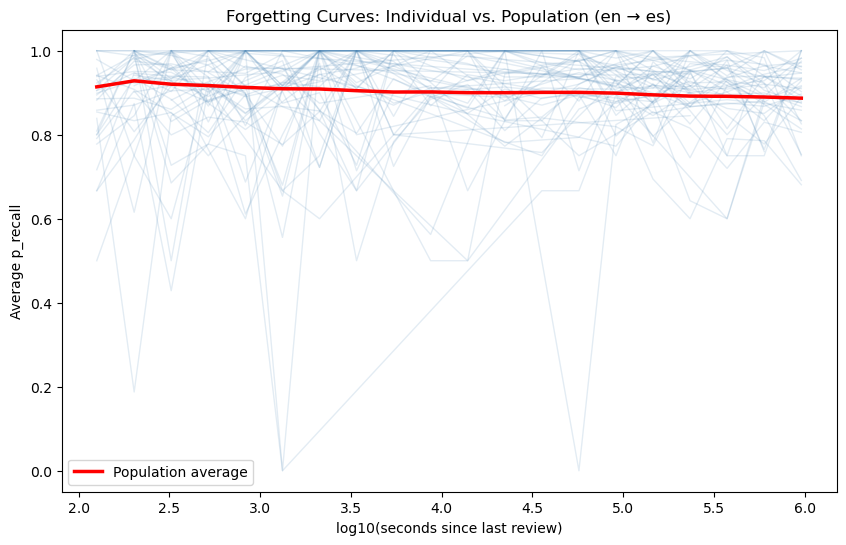


--- Step 2: Naive Half-Life Fitting ---
Fitting per-learner half-life...
Successfully fit: 11,772 users

Half-life summary (days):
count    11772.0
mean        52.5
std         44.2
min          0.0
25%         19.4
50%         43.0
75%         74.2
max        304.0
Name: half_life_days, dtype: float64


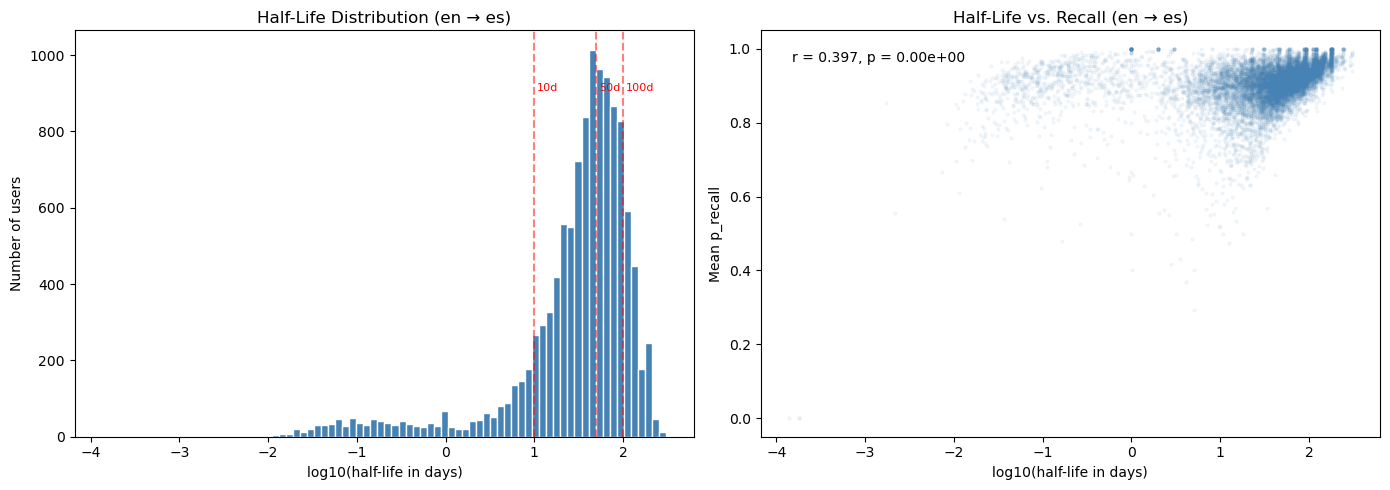


--- Step 3: Hierarchical Model ---
Sampled 500 users, 102,087 rows


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_h, sigma_log_h, z, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 536 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_log_h     3.983  0.045   3.897    4.066      0.002    0.001     884.0   
sigma_log_h  0.814  0.040   0.738    0.886      0.002    0.001     700.0   
sigma_obs    0.264  0.001   0.263    0.265      0.000    0.000    6837.0   

             ess_tail  r_hat  
mu_log_h       1685.0    1.0  
sigma_log_h    1113.0    1.0  
sigma_obs      3295.0    1.0  

--- Step 4: Shrinkage & Posterior Visualization ---
Shrinkage ratio: 0.402


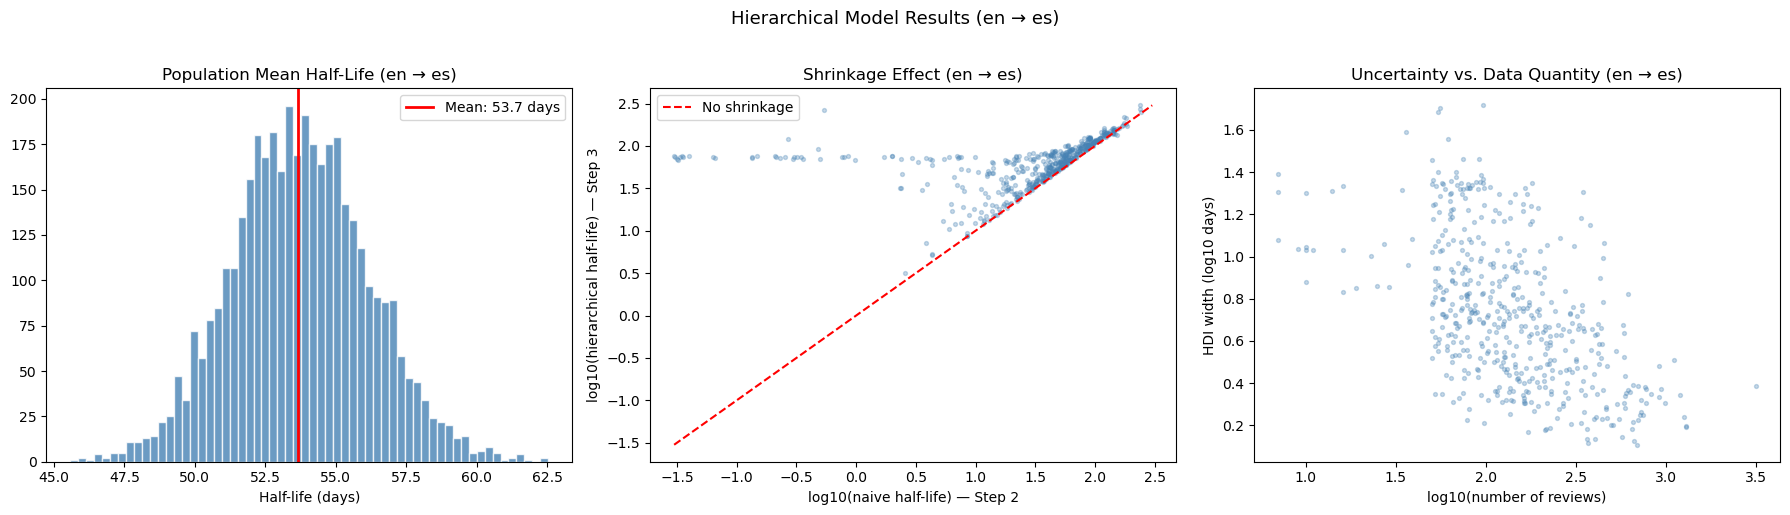


--- Step 5: Feature Engineering & Regression ---

--- Behavioral Model (en → es) ---
R²: 0.043  Adj R²: 0.036  CV R²: -0.026
Feature                                Coef       p
-------------------------------------------------------
intercept                             1.789   0.000 ***
log_n_reviews                        -0.125   0.000 ***
log_n_lexemes                         0.071   0.013 *
log_cv_delta                          0.009   0.555 
log_history_seen                      0.027   0.066 

--- Performance Model (en → es) ---
R²: 0.164  Adj R²: 0.161  CV R²: 0.124
Feature                                Coef       p
-------------------------------------------------------
intercept                             1.789   0.000 ***
mean_accuracy                         0.107   0.000 ***
log_mean_delta                        0.037   0.001 **

--- Full Model (en → es) ---
R²: 0.206  Adj R²: 0.196  CV R²: 0.131
Feature                                Coef       p
----------------------

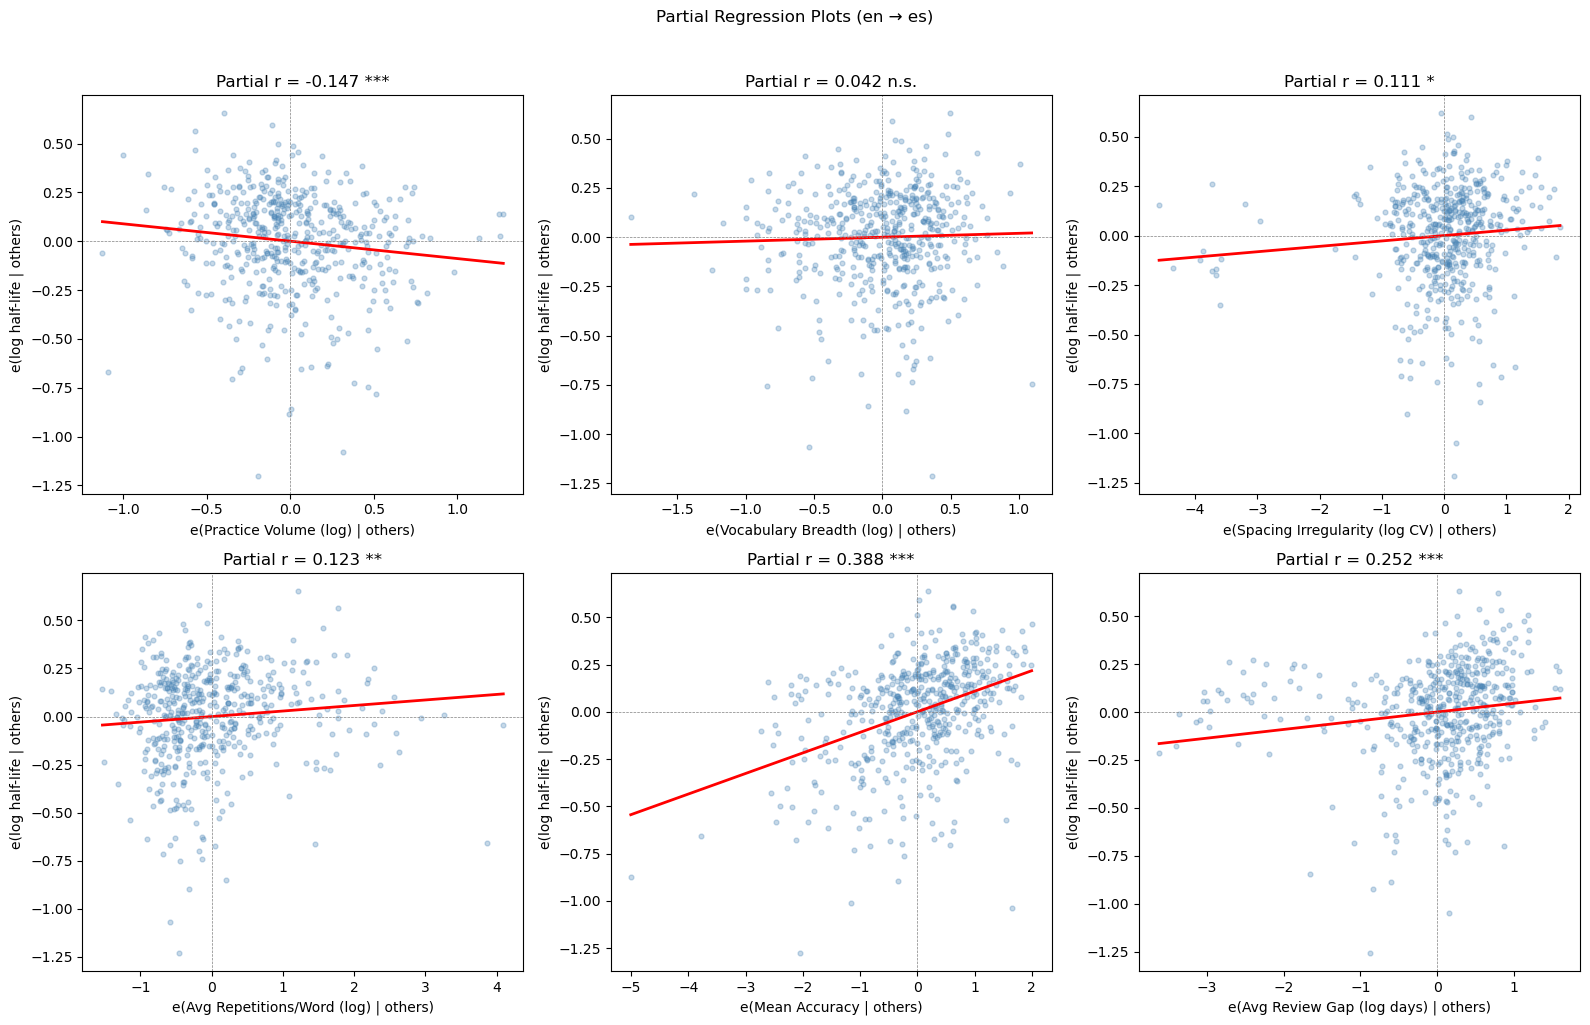


Done! (en → es)


In [17]:
# --- Run full pipeline for EN → ES ---
results_en_es = run_full_pipeline(df, ui_language='en', learning_language='es')

Language pair en → es: 2,579,121 rows, 11,772 users
Fitting per-learner half-life...
Successfully fit: 11,772 users

Half-life summary (days):
count    11772.0
mean        52.5
std         44.2
min          0.0
25%         19.4
50%         43.0
75%         74.2
max        304.0
Name: half_life_days, dtype: float64
Language pair en → fr: 1,455,317 rows, 6,631 users
Fitting per-learner half-life...
Successfully fit: 6,631 users

Half-life summary (days):
count    6631.0
mean       43.9
std        40.8
min         0.0
25%        13.9
50%        34.4
75%        60.7
max       368.0
Name: half_life_days, dtype: float64
Language pair es → en: 2,863,867 rows, 11,928 users
Fitting per-learner half-life...
Successfully fit: 11,928 users

Half-life summary (days):
count    11928.0
mean        49.9
std         44.1
min          0.0
25%         18.0
50%         39.7
75%         69.7
max        368.0
Name: half_life_days, dtype: float64


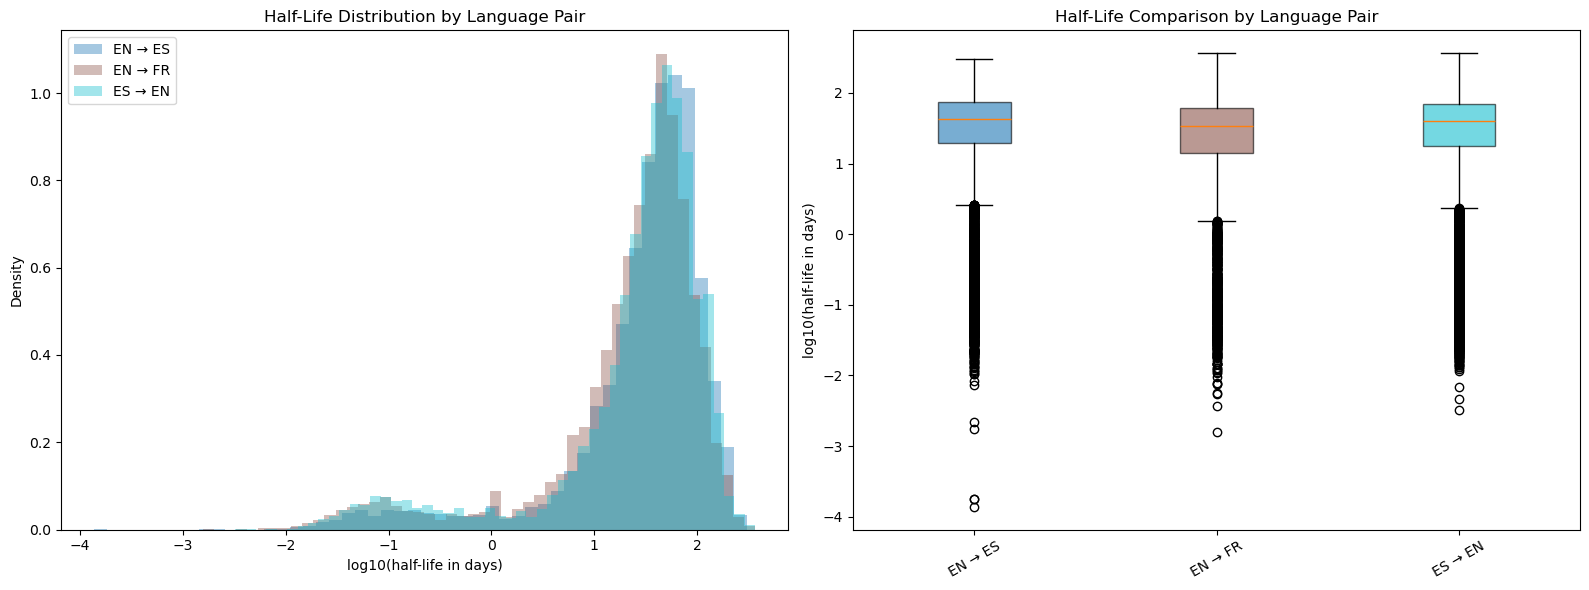


Summary statistics by language pair:
         median  mean   std  count
pair                              
EN → ES    43.0  52.5  44.2  11772
EN → FR    34.4  43.9  40.8   6631
ES → EN    39.7  49.9  44.1  11928


In [19]:
# --- Compare EN → ES vs EN → FR vs ES → EN ---
comparison_df = compare_language_pairs(df, pairs_to_compare=['en_es', 'en_fr', 'es_en'])


Running full pipeline for (es → en)

Language pair es → en: 2,863,867 rows, 11,928 users

--- Step 1: Forgetting Curves ---


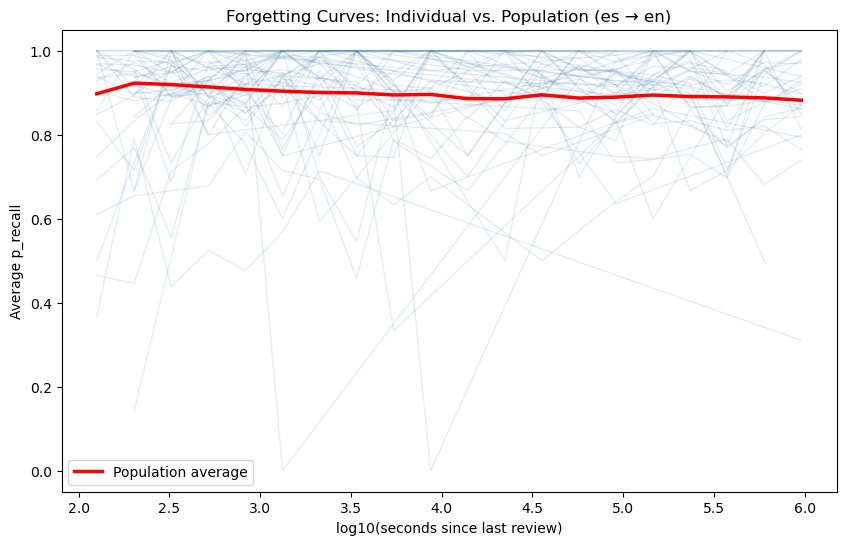


--- Step 2: Naive Half-Life Fitting ---
Fitting per-learner half-life...
Successfully fit: 11,928 users

Half-life summary (days):
count    11928.0
mean        49.9
std         44.1
min          0.0
25%         18.0
50%         39.7
75%         69.7
max        368.0
Name: half_life_days, dtype: float64


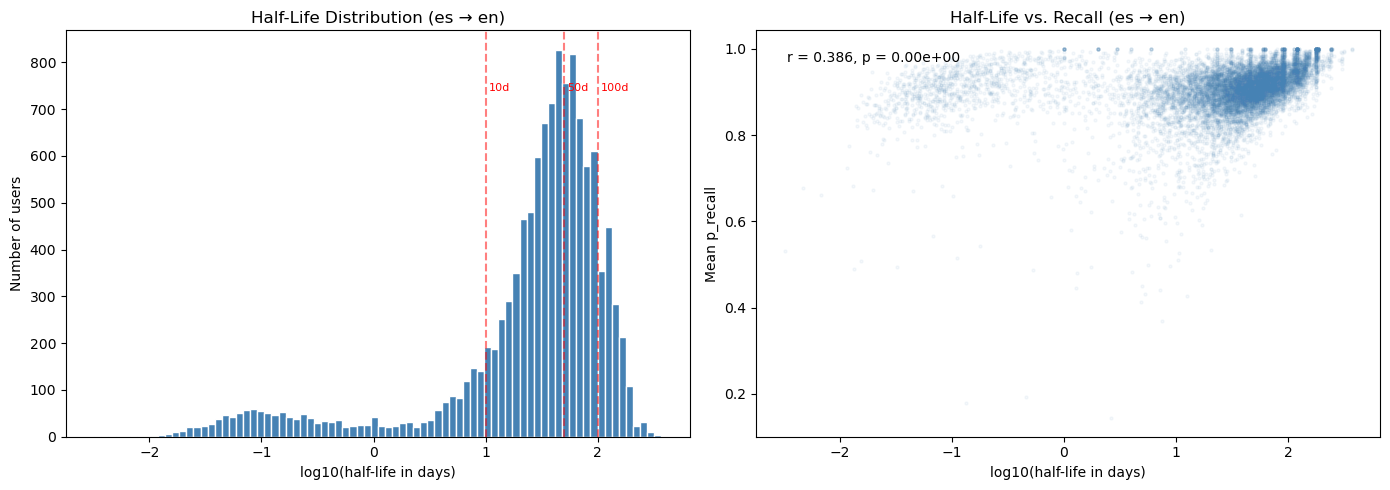


--- Step 3: Hierarchical Model ---
Sampled 500 users, 117,395 rows


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_h, sigma_log_h, z, sigma_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 473 seconds.


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_log_h     3.935  0.055   3.838    4.041      0.002    0.001     695.0   
sigma_log_h  0.974  0.047   0.881    1.057      0.002    0.001     688.0   
sigma_obs    0.264  0.001   0.263    0.265      0.000    0.000    8839.0   

             ess_tail  r_hat  
mu_log_h       1197.0   1.00  
sigma_log_h    1249.0   1.01  
sigma_obs      2682.0   1.00  

--- Step 4: Shrinkage & Posterior Visualization ---
Shrinkage ratio: 0.452


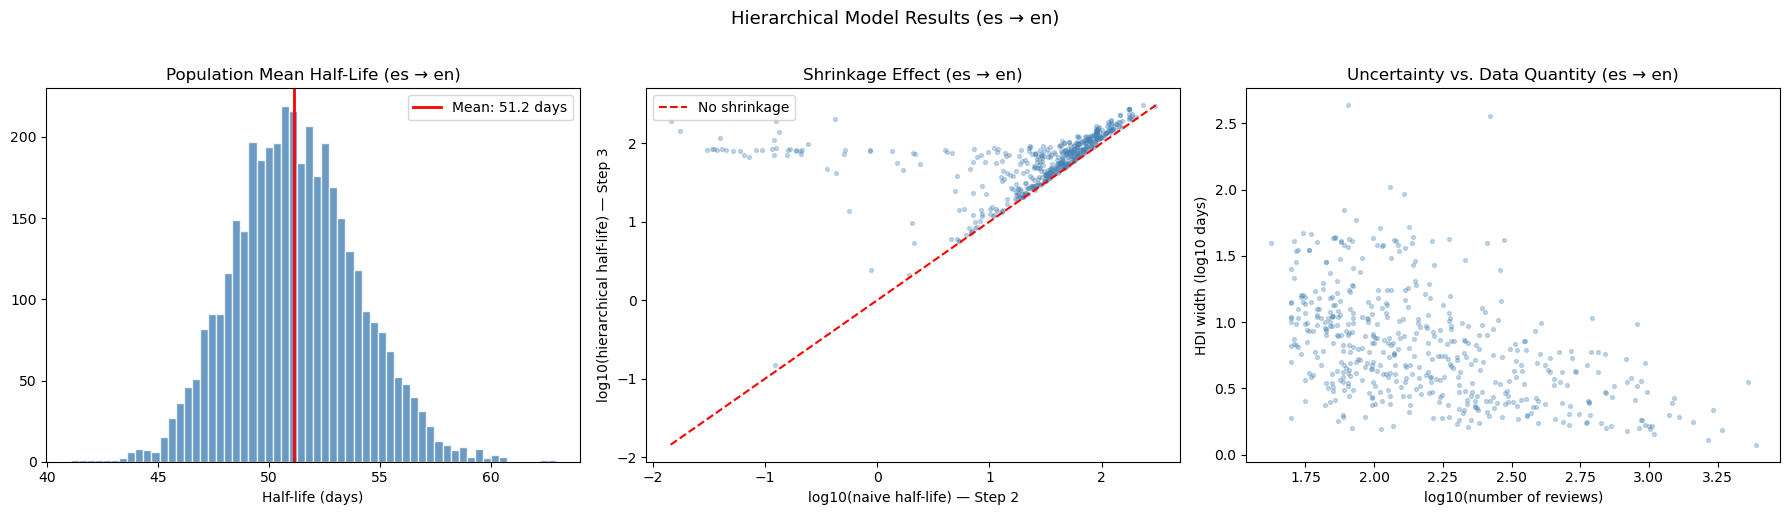


--- Step 5: Feature Engineering & Regression ---

--- Behavioral Model (es → en) ---
R²: 0.045  Adj R²: 0.037  CV R²: -0.009
Feature                                Coef       p
-------------------------------------------------------
intercept                             1.785   0.000 ***
log_n_reviews                        -0.132   0.000 ***
log_n_lexemes                         0.057   0.071 
log_cv_delta                          0.029   0.149 
log_history_seen                      0.053   0.011 *

--- Performance Model (es → en) ---
R²: 0.205  Adj R²: 0.201  CV R²: 0.128
Feature                                Coef       p
-------------------------------------------------------
intercept                             1.785   0.000 ***
mean_accuracy                         0.147   0.000 ***
log_mean_delta                        0.058   0.000 ***

--- Full Model (es → en) ---
R²: 0.263  Adj R²: 0.254  CV R²: 0.173
Feature                                Coef       p
---------------------

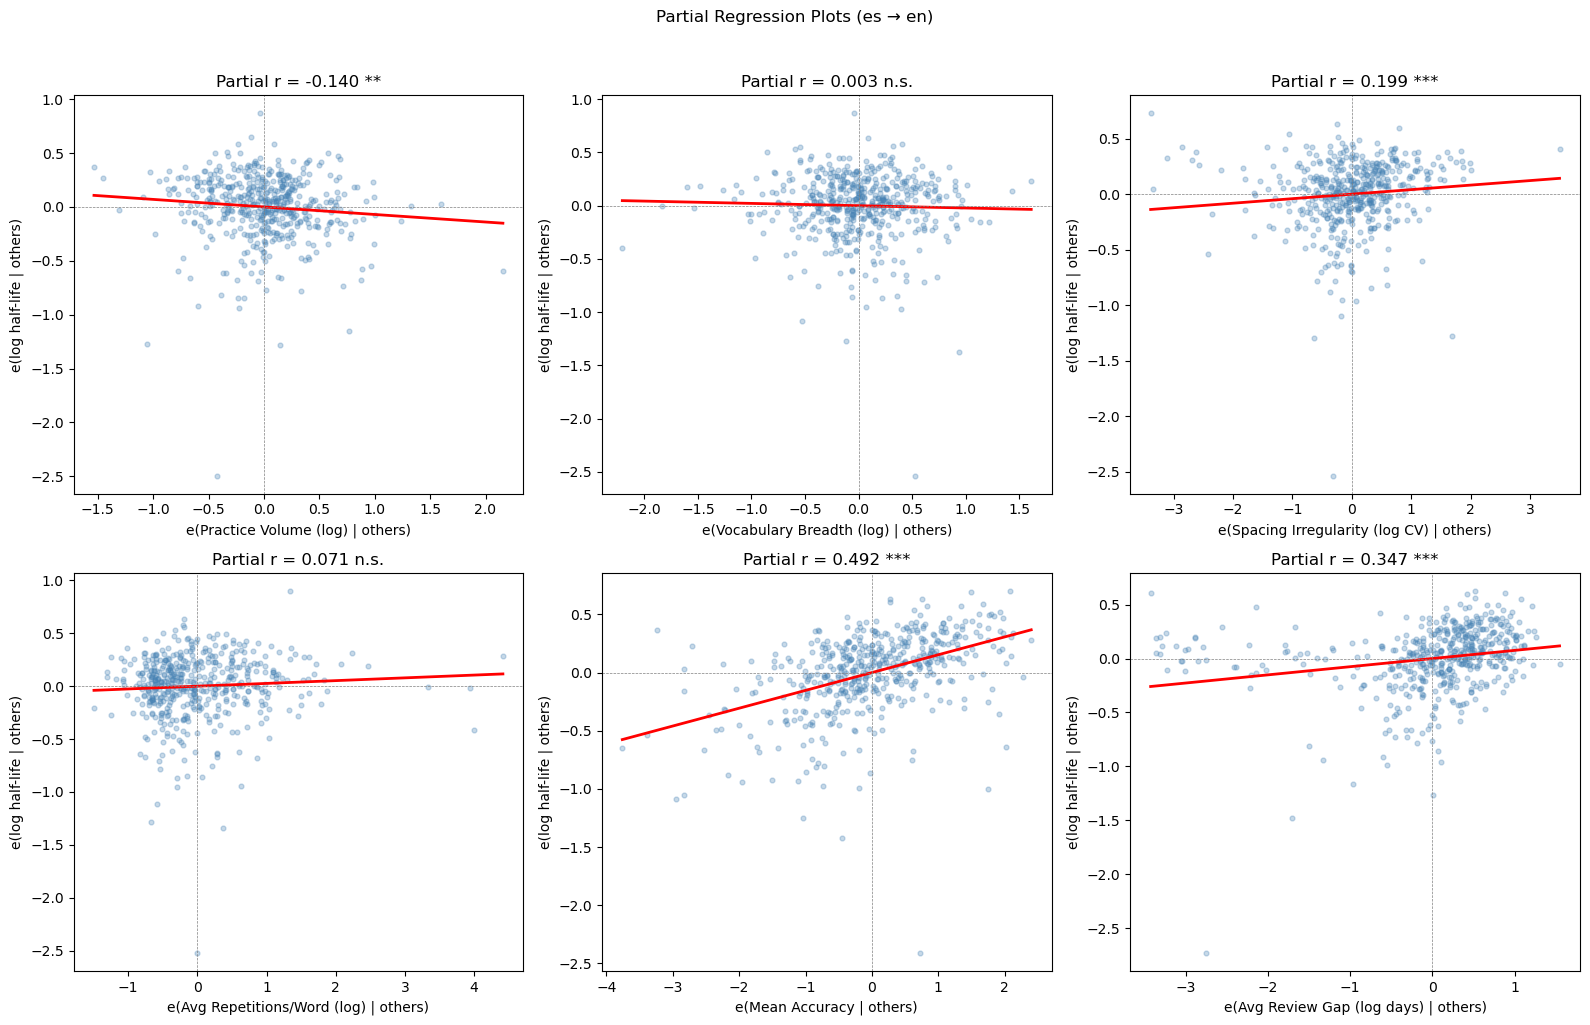


Done! (es → en)


In [20]:
# --- Run full pipeline for ES → EN ---
results_es_en = run_full_pipeline(df, ui_language='es', learning_language='en')

Estimating lexeme difficulty...
Fitting half-life for 1,975 lexemes...

Lexeme difficulty summary:
Total lexemes with >= 30 obs: 1,975

Hardest 10 lexemes (lowest mean p_recall):
                       lexeme_id  mean_p_recall  n_observations  lex_half_life_days
392bdde96dfe430ecb1b12467c4878d8       0.477778              45            4.202437
58a5e4f8624f5bfadbac373b3a9f7e49       0.538652              94            3.550087
7aa5807f2e31d0de6287d1a883798824       0.593939              55           10.998506
9eea8c46d07f1e21ef116607649f827d       0.602381              42           10.004597
35464182dc67c97fbffcc4a468c6cdf1       0.628788              33            8.157567
3dd45e18c5354740967f8b09888058d4       0.634146              41            5.571734
6c5b33db379c429c997ca7c87635203c       0.642276              41            7.956780
c7a50cf910b305a94b3788b03e1d7e9f       0.645161              31           14.547752
e5b279f87bbdd6422ed3ca8431e72ed5       0.657692             104  

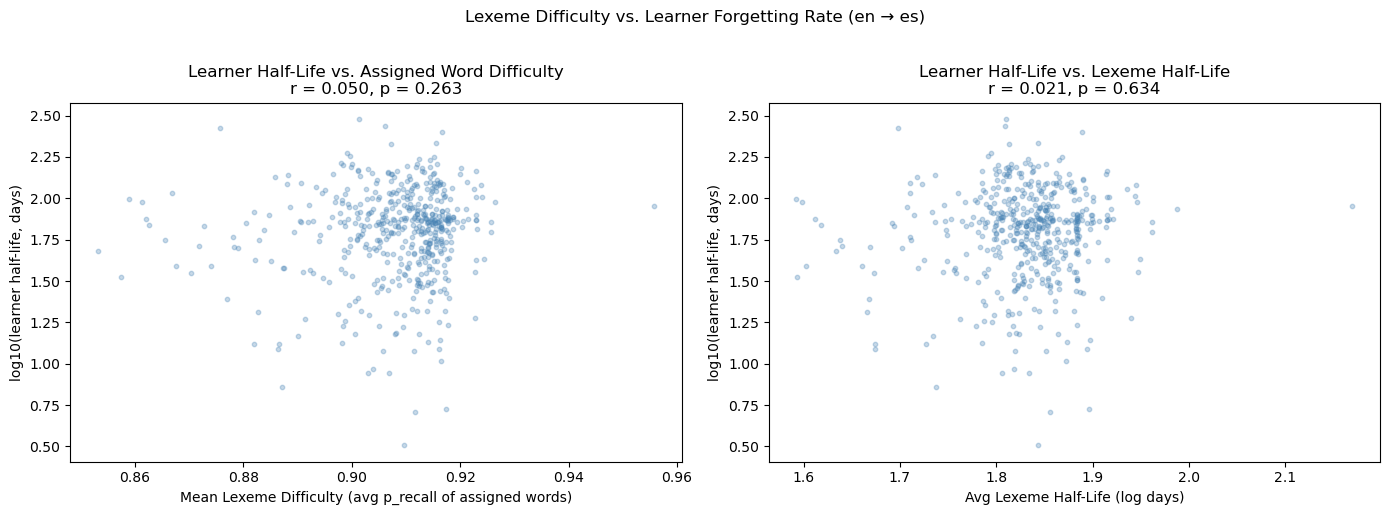

In [26]:
lexeme_df = estimate_lexeme_difficulty(results_en_es['subset'])

features_enriched = add_lexeme_difficulty_to_features(
    results_en_es['features_df'], 
    results_en_es['subset'], 
    lexeme_df
)

run_enriched_regression(features_enriched, title_suffix='(en → es)')

Clustering on 500 learners with features: ['log_h', 'mean_accuracy', 'log_mean_delta', 'log_n_reviews', 'log_cv_delta']


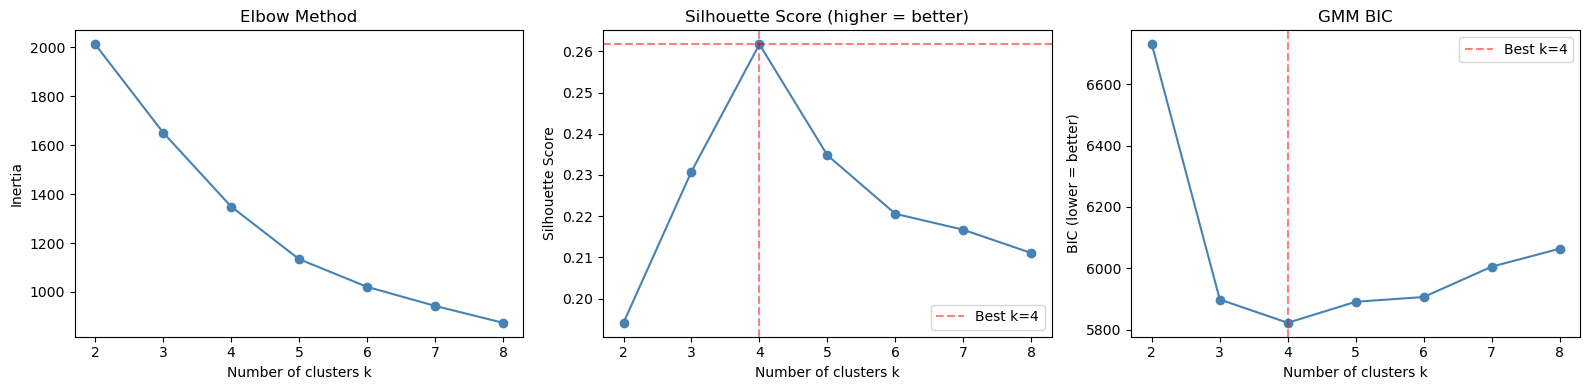


Silhouette suggests k = 4
GMM BIC suggests k   = 4

Cluster profiles:
         log_h  mean_accuracy  log_mean_delta  log_n_reviews  log_cv_delta  \
cluster                                                                      
0.0      1.827          0.903          -1.310          1.907         0.084   
1.0      1.481          0.866           0.172          2.254         0.036   
2.0      1.933          0.922           0.378          2.159         0.022   
3.0      1.957          0.946           0.415          1.117        -1.862   

         h_hierarchical  
cluster                  
0.0              68.577  
1.0              35.282  
2.0              93.261  
3.0              94.225  

Cluster sizes:
cluster
0.0     60
1.0    146
2.0    282
3.0     12
Name: count, dtype: int64


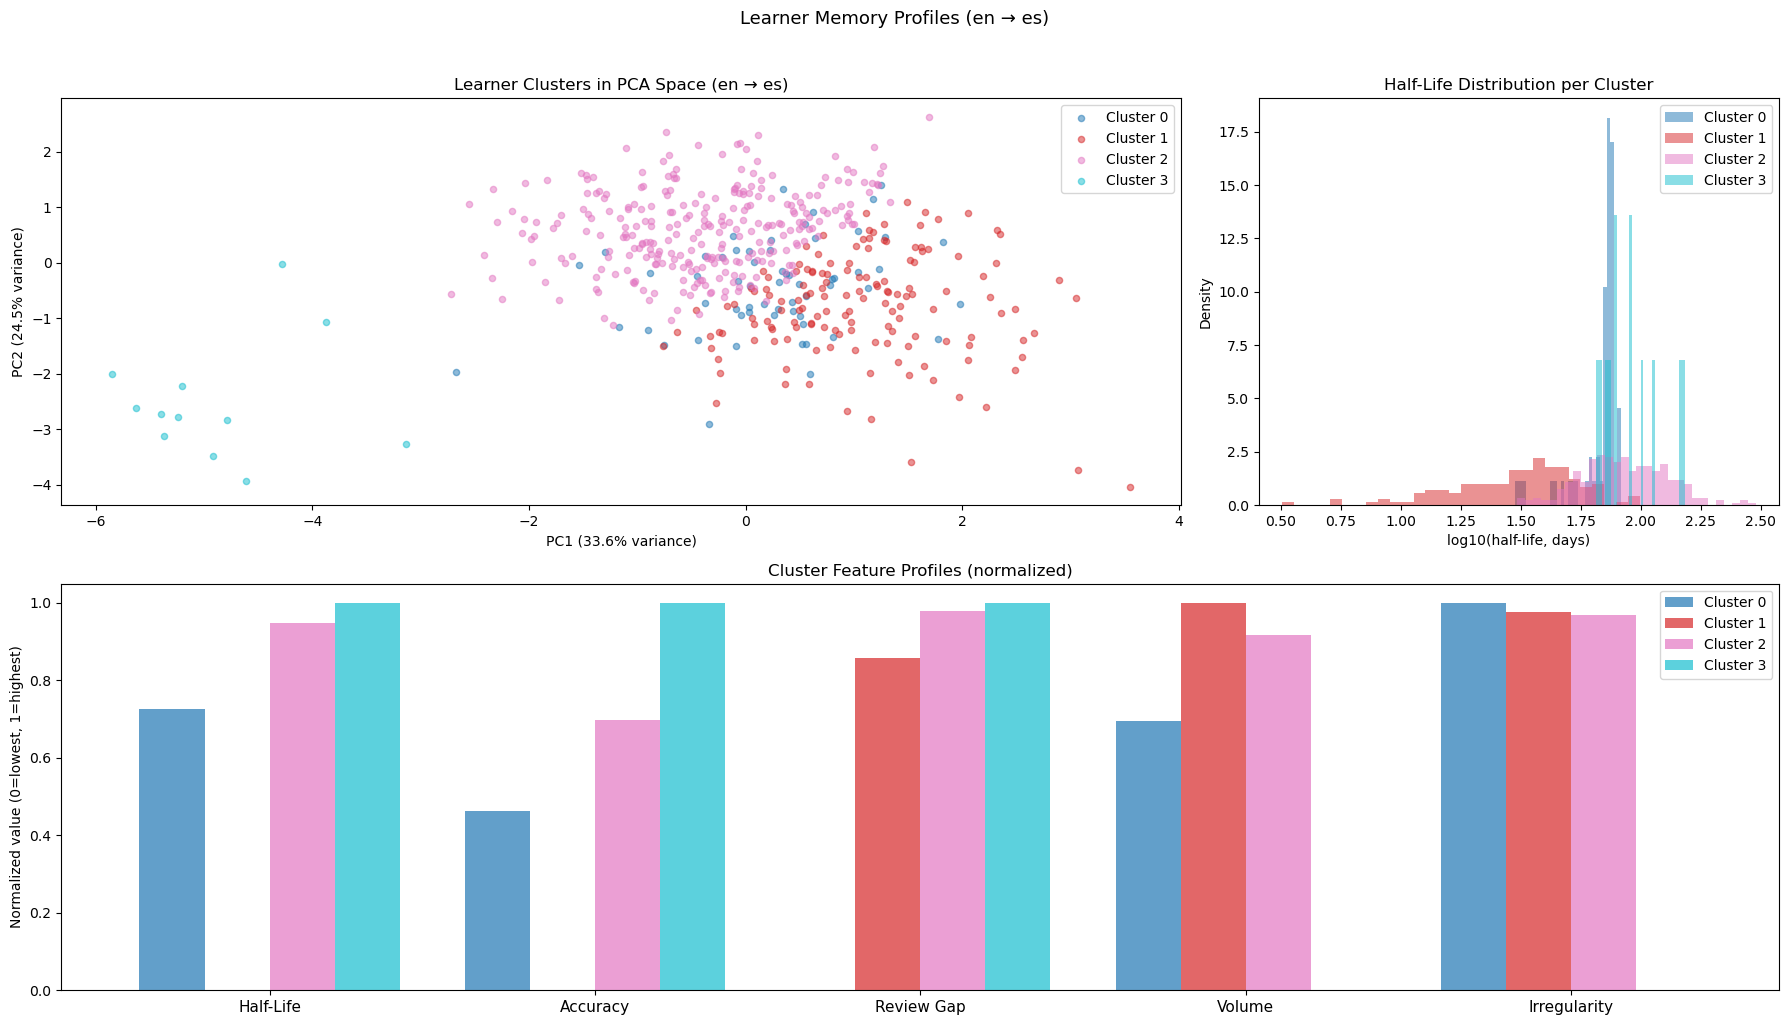

In [32]:
X_scaled, valid_idx, cluster_feats, scaler = prepare_clustering_features(
    features_enriched)

# Find optimal k
best_k_sil, best_k_bic = find_optimal_clusters(X_scaled)

# Pick k (use silhouette suggestion, or override manually)
k = best_k_sil  # or set k = 4 if you want to try a specific value

features_clustered = fit_and_profile_clusters(
    features_enriched, X_scaled, valid_idx, cluster_feats, 
    k=k, title_suffix='(en → es)')

In [33]:
cluster_names = {
    0.0: 'Disengaged Fast Forgetters',
    1.0: 'Struggling Learners',
    2.0: 'Solid Performers',
    3.0: 'Natural Learners'
}
features_clustered['cluster_name'] = features_clustered['cluster'].map(cluster_names)
print(features_clustered['cluster_name'].value_counts())

cluster_name
Solid Performers              282
Struggling Learners           146
Disengaged Fast Forgetters     60
Natural Learners               12
Name: count, dtype: int64


Computing temporal half-lives across 3 phases...
Fitted 1,290 phase estimates across 430 learners


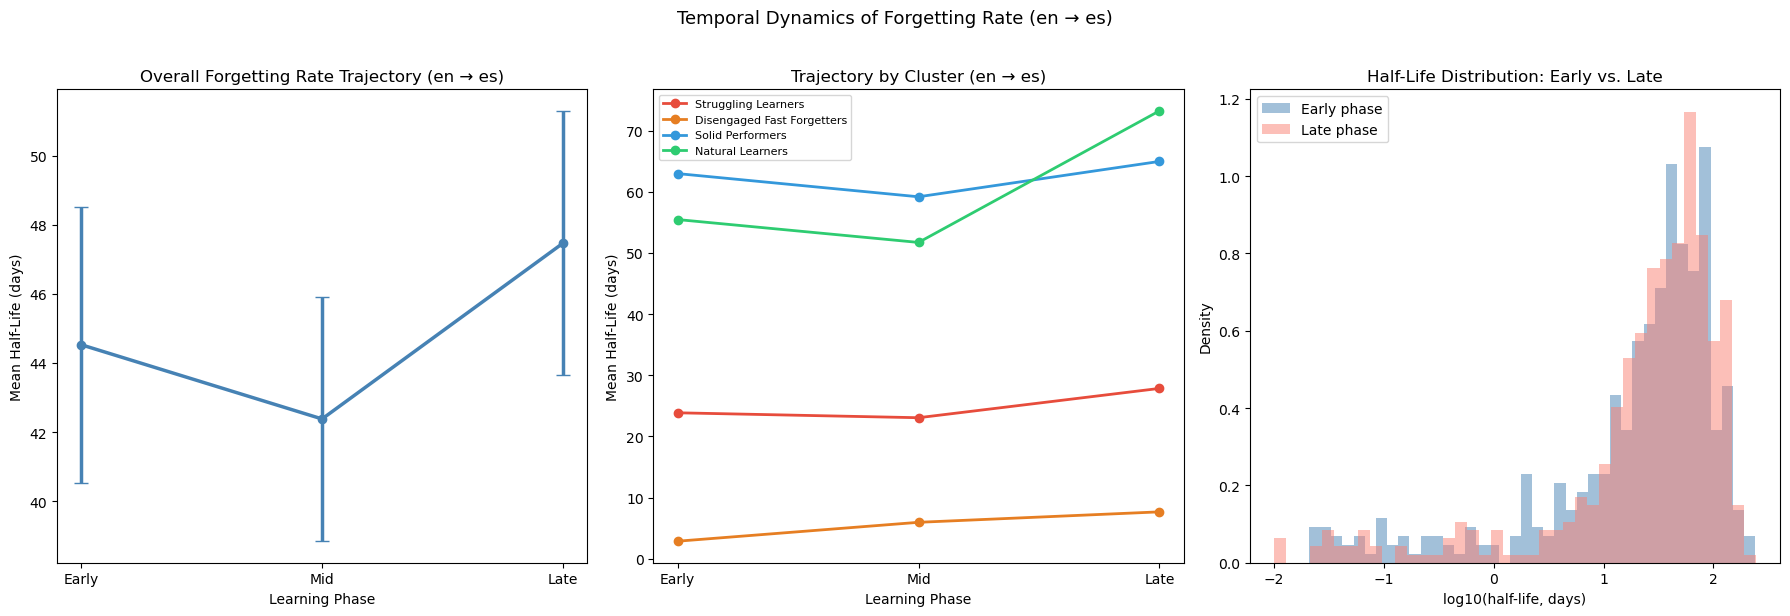


Paired Wilcoxon test (Early vs Late half-life):
  Early mean: 44.5 days
  Late mean:  47.5 days
  Half-life increased from early to late phase
  W = 40589.0, p = 0.0380 * significant

Early vs Late by cluster:
Cluster                           Early     Late   Change        p
------------------------------------------------------------
Struggling Learners                23.9     27.8     +4.0        *
Disengaged Fast Forgetters          2.9      7.7     +4.8        *
Solid Performers                   63.0     65.0     +2.0     n.s.


In [36]:
temporal_df = compute_temporal_halflife(
    results_en_es['subset'],      # or df_filtered filtered to en→es
    features_clustered,
    n_phases=3,
    min_reviews_per_phase=20,
    title_suffix='(en → es)'
)

paired_pivot = plot_temporal_dynamics(temporal_df, title_suffix='(en → es)')


--- Main Effects Only (en → es) ---
R²: 0.199  Adj R²: 0.193  CV R²: 0.145
Feature                           Coef       p
--------------------------------------------------
intercept                        1.789   0.000 ***
Mean Accuracy                    0.107   0.000 ***
Review Gap                       0.049   0.000 ***
Practice Volume                 -0.061   0.000 ***
Spacing Irregularity             0.028   0.042 *

--- Main + Interactions (en → es) ---
R²: 0.226  Adj R²: 0.215  CV R²: 0.165
Feature                           Coef       p
--------------------------------------------------
intercept                        1.790   0.000 ***
Mean Accuracy                    0.114   0.000 ***
Review Gap                       0.047   0.000 ***
Practice Volume                 -0.062   0.000 ***
Spacing Irregularity             0.012   0.404 
Accuracy × Consistency           0.002   0.897 
Accuracy × Review Gap            0.020   0.079 
Accuracy × Volume                0.037   0.008 **

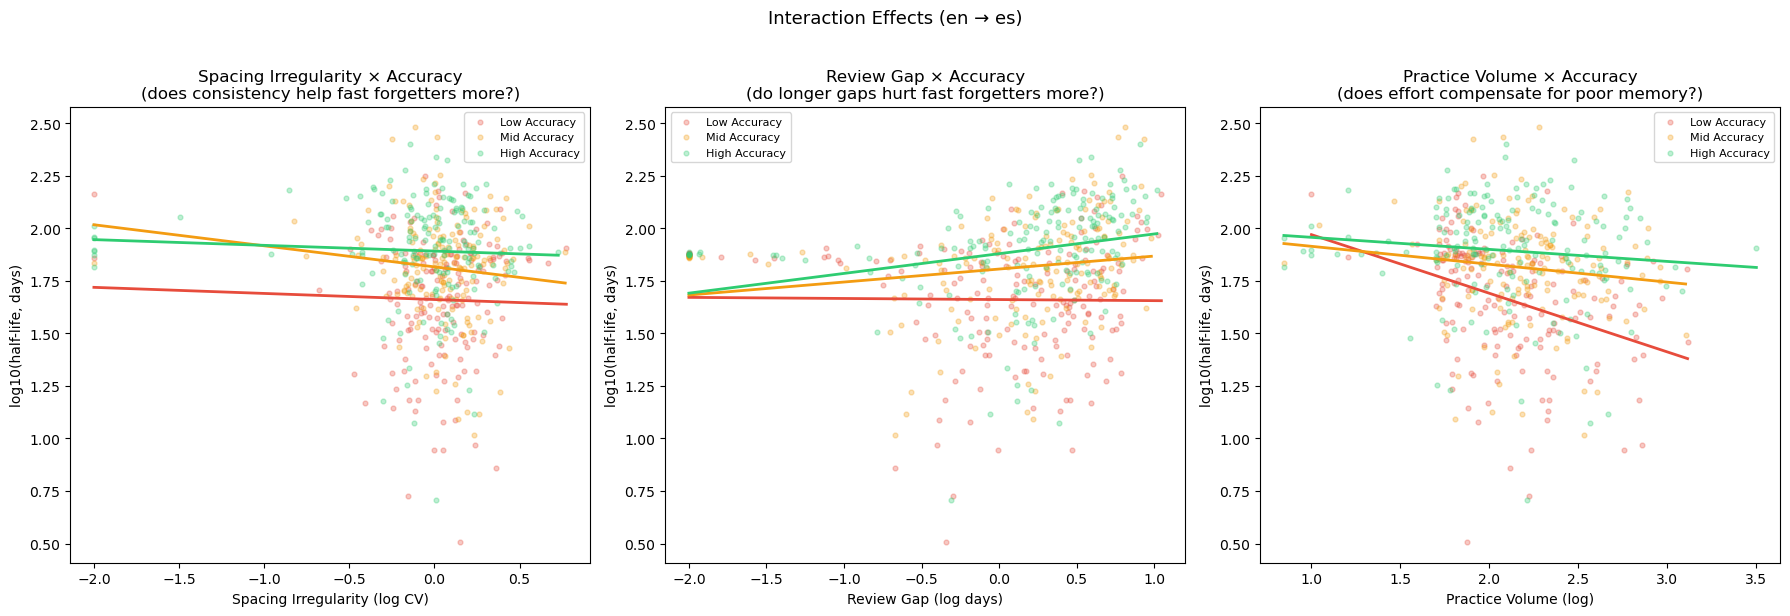

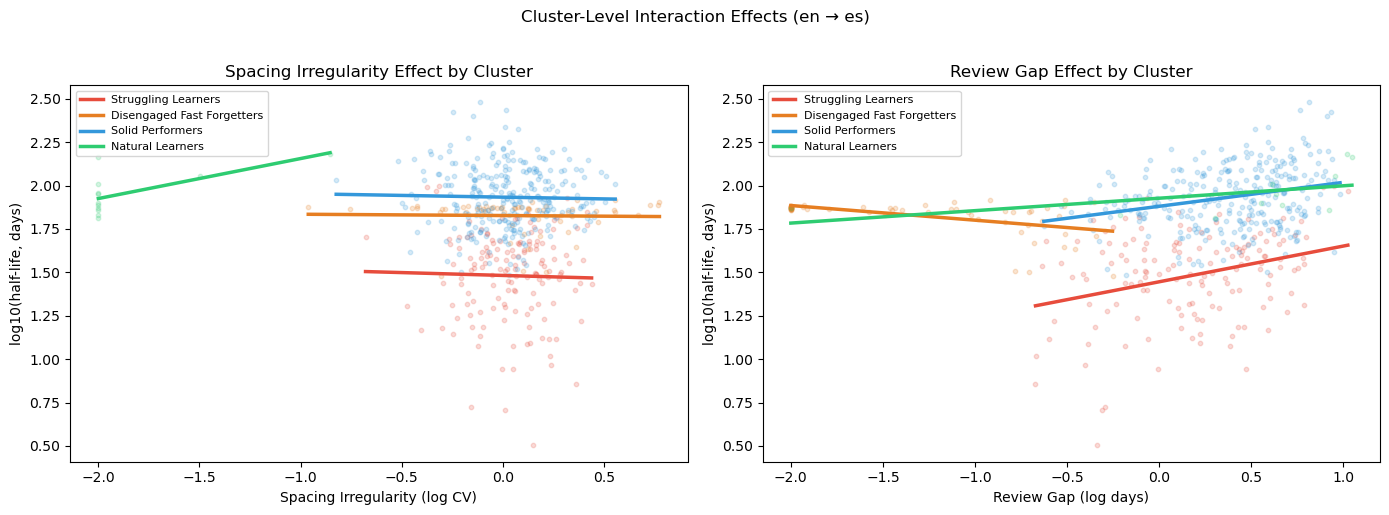

In [38]:
model_inter = run_interaction_analysis(features_clustered, title_suffix='(en → es)')

In [39]:
# =============================================================================
# EXTRACT STRUGGLING LEARNERS ACROSS ALL LANGUAGE PAIRS
# =============================================================================

def extract_struggling_learners_all_pairs(df_filtered, threshold_quantile=0.25,
                                           min_reviews=50, save_csv=True):
    """
    Identify and extract Struggling Learners across all language pairs.
    
    Struggling Learners are defined as users in the bottom quantile of 
    half-life within their language pair (default: bottom 25%).

    Parameters
    ----------
    df_filtered          : full filtered DataFrame from load_and_filter()
    threshold_quantile   : quantile cutoff for "struggling" (default: 0.25)
    min_reviews          : minimum reviews per user (default: 50)
    save_csv             : whether to save output to CSV

    Returns
    -------
    df_struggling_all    : full review history of struggling learners
    struggling_summary   : per-user summary with half-life and language pair
    """

    all_naive = []
    pair_summaries = []

    # --- Step 1: fit naive half-life per language pair ---
    pairs_found = df_filtered.groupby(['ui_language', 'learning_language']).size()
    print(f"Language pairs found: {len(pairs_found)}")
    print(pairs_found.to_string())

    for (ui_lang, learn_lang), group in df_filtered.groupby(
            ['ui_language', 'learning_language']):

        pair_label = f"{ui_lang}→{learn_lang}"
        print(f"\nFitting half-lives for {pair_label} "
              f"({group['user_id'].nunique():,} users)...")

        # Filter to users with enough reviews
        user_counts = group.groupby('user_id').size()
        eligible = user_counts[user_counts >= min_reviews].index
        group_eligible = group[group['user_id'].isin(eligible)]

        if len(eligible) < 10:
            print(f"  Skipping {pair_label} — too few eligible users ({len(eligible)})")
            continue

        # Fit naive half-life
        naive = fit_naive_halflife(group_eligible)
        naive['ui_language']       = ui_lang
        naive['learning_language'] = learn_lang
        naive['pair_label']        = pair_label

        # Define struggling threshold within this pair
        threshold = naive['half_life_days'].quantile(threshold_quantile)
        naive['is_struggling'] = naive['half_life_days'] <= threshold
        naive['hl_percentile'] = naive['half_life_days'].rank(pct=True)

        n_struggling = naive['is_struggling'].sum()
        print(f"  Threshold ({threshold_quantile:.0%} quantile): "
              f"{threshold:.1f} days | Struggling: {n_struggling:,} users")

        pair_summaries.append({
            'pair_label':    pair_label,
            'total_users':   len(naive),
            'n_struggling':  n_struggling,
            'hl_threshold':  threshold,
            'median_hl':     naive['half_life_days'].median()
        })

        all_naive.append(naive)

    # --- Step 2: combine all pairs ---
    all_naive_df = pd.concat(all_naive, ignore_index=True)
    struggling_users = all_naive_df[all_naive_df['is_struggling']]['user_id'].values

    print(f"\n{'='*60}")
    print(f"Total users across all pairs:    {len(all_naive_df):,}")
    print(f"Total struggling learners:       {len(struggling_users):,} "
          f"({100*len(struggling_users)/len(all_naive_df):.1f}%)")

    # --- Step 3: extract full review history ---
    df_struggling_all = df_filtered[
        df_filtered['user_id'].isin(struggling_users)
    ].copy()

    # Merge in user-level metadata
    df_struggling_all = df_struggling_all.merge(
        all_naive_df[['user_id', 'half_life_days', 'hl_percentile',
                      'pair_label', 'ui_language', 'learning_language']],
        on='user_id', how='left'
    )

    print(f"Total reviews from struggling learners: {len(df_struggling_all):,}")

    # --- Step 4: summary table ---
    summary_df = pd.DataFrame(pair_summaries)
    print(f"\nPer language pair breakdown:")
    print(summary_df.to_string(index=False))

    # --- Step 5: quick visualization ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: struggling count per language pair
    summary_df_sorted = summary_df.sort_values('n_struggling', ascending=True)
    axes[0].barh(summary_df_sorted['pair_label'],
                 summary_df_sorted['n_struggling'],
                 color='steelblue', edgecolor='white')
    axes[0].set_xlabel('Number of Struggling Learners')
    axes[0].set_title('Struggling Learners per Language Pair\n'
                      f'(bottom {threshold_quantile:.0%} half-life within each pair)')

    # Right: half-life distributions with threshold marked per pair
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_naive_df['pair_label'].unique())))
    for (pair, pdf), color in zip(all_naive_df.groupby('pair_label'), colors):
        axes[1].hist(np.log10(pdf['half_life_days'].clip(lower=0.01)),
                     bins=40, alpha=0.4, density=True,
                     color=color, label=pair)
    axes[1].set_xlabel('log10(half-life, days)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Half-Life Distributions by Language Pair\n'
                      '(struggling = left tail of each)')
    axes[1].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

    # --- Step 6: save ---
    if save_csv:
        df_struggling_all.to_csv('struggling_learners_all_pairs.csv', index=False)
        all_naive_df[all_naive_df['is_struggling']].to_csv(
            'struggling_learners_summary.csv', index=False)
        print(f"\nSaved:")
        print(f"  struggling_learners_all_pairs.csv  — full review history")
        print(f"  struggling_learners_summary.csv    — one row per user with metadata")

    return df_struggling_all, all_naive_df[all_naive_df['is_struggling']]

Language pairs found: 8
ui_language  learning_language
en           de                   1104152
             es                   2579121
             fr                   1455317
             it                    674950
             pt                    251888
es           en                   2863867
it           en                    337062
pt           en                    747969

Fitting half-lives for en→de (5,171 users)...
Fitting per-learner half-life...
Successfully fit: 4,774 users

Half-life summary (days):
count    4774.0
mean       49.7
std        42.8
min         0.0
25%        18.3
50%        39.4
75%        69.0
max       368.0
Name: half_life_days, dtype: float64
  Threshold (25% quantile): 18.3 days | Struggling: 1,194 users

Fitting half-lives for en→es (11,772 users)...
Fitting per-learner half-life...
Successfully fit: 11,386 users

Half-life summary (days):
count    11386.0
mean        53.2
std         44.2
min          0.0
25%         20.3
50%         43.6
75

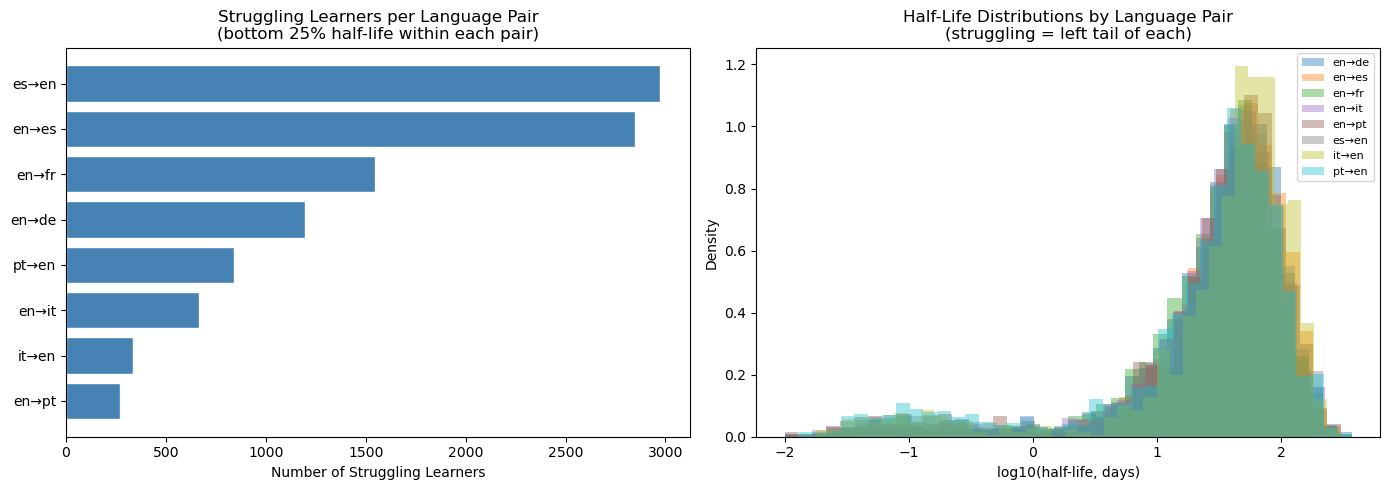


Saved:
  struggling_learners_all_pairs.csv  — full review history
  struggling_learners_summary.csv    — one row per user with metadata


In [41]:
df_struggling_all, struggling_summary = extract_struggling_learners_all_pairs(
    df,
    threshold_quantile=0.25,  # bottom 25% within each pair
    save_csv=True
)

In [30]:
def extract_struggling_learners_all_pairs(df_filtered, save_csv=True):
    """
    Extract Struggling Learners across all language pairs using a 
    multi-feature definition that matches the cluster profile:
    
    Struggling = bottom 35% half-life
               + below median accuracy  
               + above median practice volume
               + above median review gap  ← this excludes Disengaged Fast Forgetters
                                            who have very short gaps
    """
    all_naive = []
    pair_summaries = []

    for (ui_lang, learn_lang), group in df_filtered.groupby(
        ['ui_language', 'learning_language']):

        pair_label = f"{ui_lang}→{learn_lang}"
        print(f"\nProcessing {pair_label} "
            f"({group['user_id'].nunique():,} users)...")

        user_counts = group.groupby('user_id').size()
        eligible = user_counts[user_counts >= 50].index
        group_eligible = group[group['user_id'].isin(eligible)]

        if len(eligible) < 10:
            print(f"  Skipping — too few eligible users")
            continue

        # Fit naive half-life (already includes n_reviews)
        naive = fit_naive_halflife(group_eligible)
        naive['ui_language']       = ui_lang
        naive['learning_language'] = learn_lang
        naive['pair_label']        = pair_label

        # Compute additional behavioral features (NOT n_reviews — already in naive)
        user_features = []
        for user_id, udf in group_eligible.groupby('user_id'):
            user_features.append({
                'user_id':         user_id,
                'mean_accuracy':   (udf['history_correct'] /
                                udf['history_seen'].clip(lower=1)).mean(),
                'mean_delta_days': udf['delta'].mean() / 86400,
            })
        feat_df = pd.DataFrame(user_features)
        naive = naive.merge(feat_df, on='user_id', how='left')

        # Thresholds
        hl_thresh  = naive['half_life_days'].quantile(0.35)
        acc_thresh = naive['mean_accuracy'].quantile(0.50)
        vol_thresh = naive['n_reviews'].quantile(0.50)
        gap_thresh = naive['mean_delta_days'].quantile(0.35)

        naive['is_struggling'] = (
            (naive['half_life_days'] <= hl_thresh)   &
            (naive['mean_accuracy']  <= acc_thresh)  &
            (naive['n_reviews']      >= vol_thresh)  &
            (naive['mean_delta_days']>= gap_thresh)
        )
        naive['hl_percentile'] = naive['half_life_days'].rank(pct=True)

        n_struggling = naive['is_struggling'].sum()
        pct = 100 * n_struggling / len(naive)
        print(f"  Struggling: {n_struggling:,} users ({pct:.1f}%)")
        print(f"  Thresholds — HL: {hl_thresh:.1f}d | "
            f"Acc: {acc_thresh:.3f} | "
            f"Vol: {vol_thresh:.0f} reviews | "
            f"Gap: {gap_thresh:.2f}d")

        pair_summaries.append({
            'pair_label':   pair_label,
            'total_users':  len(naive),
            'n_struggling': n_struggling,
            'pct':          pct,
            'hl_threshold': hl_thresh,
        })
        all_naive.append(naive)
    # --- Combine ---
    all_naive_df = pd.concat(all_naive, ignore_index=True)
    struggling_users = all_naive_df[all_naive_df['is_struggling']]['user_id'].values

    print(f"\n{'='*60}")
    print(f"Total users:             {len(all_naive_df):,}")
    print(f"Total struggling:        {len(struggling_users):,} "
          f"({100*len(struggling_users)/len(all_naive_df):.1f}%)")

    # --- Extract full review history ---
    df_struggling_all = df_filtered[
        df_filtered['user_id'].isin(struggling_users)
    ].copy()
    df_struggling_all = df_struggling_all.merge(
        all_naive_df[['user_id', 'half_life_days', 'hl_percentile',
                      'pair_label', 'ui_language', 'learning_language',
                      'mean_accuracy', 'mean_delta_days', 'n_reviews']],
        on='user_id', how='left'
    )

    print(f"Total reviews:           {len(df_struggling_all):,}")

    # --- Summary table ---
    summary_df = pd.DataFrame(pair_summaries)
    print(f"\nPer language pair:")
    print(summary_df.to_string(index=False))

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    summary_sorted = summary_df.sort_values('n_struggling', ascending=True)
    axes[0].barh(summary_sorted['pair_label'], summary_sorted['n_struggling'],
                 color='#e74c3c', edgecolor='white', alpha=0.8)
    axes[0].set_xlabel('Number of Struggling Learners')
    axes[0].set_title('Struggling Learners per Language Pair\n'
                      '(low HL + low accuracy + high volume + non-bursty)')

    # Half-life distribution: struggling vs rest
    struggling_hl = np.log10(
        all_naive_df[all_naive_df['is_struggling']]['half_life_days'].clip(lower=0.01))
    rest_hl = np.log10(
        all_naive_df[~all_naive_df['is_struggling']]['half_life_days'].clip(lower=0.01))
    axes[1].hist(rest_hl, bins=60, alpha=0.5, density=True,
                 color='steelblue', label='Other learners')
    axes[1].hist(struggling_hl, bins=60, alpha=0.6, density=True,
                 color='#e74c3c', label='Struggling Learners')
    axes[1].set_xlabel('log10(half-life, days)')
    axes[1].set_ylabel('Density')
    axes[1].set_title('Half-Life: Struggling vs. Rest')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # --- Save ---
    if save_csv:
        df_struggling_all.to_csv('struggling_learners_all_pairs.csv', index=False)
        all_naive_df[all_naive_df['is_struggling']].to_csv(
            'struggling_learners_summary.csv', index=False)
        print(f"\nSaved:")
        print(f"  struggling_learners_all_pairs.csv — full review history")
        print(f"  struggling_learners_summary.csv   — one row per user")

    return df_struggling_all, all_naive_df[all_naive_df['is_struggling']]


Processing en→de (5,171 users)...
Fitting per-learner half-life...
Successfully fit: 4,774 users

Half-life summary (days):
count    4774.0
mean       49.7
std        42.8
min         0.0
25%        18.3
50%        39.4
75%        69.0
max       368.0
Name: half_life_days, dtype: float64
  Struggling: 198 users (4.1%)
  Thresholds — HL: 26.9d | Acc: 0.906 | Vol: 132 reviews | Gap: 1.19d

Processing en→es (11,772 users)...
Fitting per-learner half-life...
Successfully fit: 11,386 users

Half-life summary (days):
count    11386.0
mean        53.2
std         44.2
min          0.0
25%         20.3
50%         43.6
75%         74.6
max        304.0
Name: half_life_days, dtype: float64
  Struggling: 431 users (3.8%)
  Thresholds — HL: 29.3d | Acc: 0.903 | Vol: 131 reviews | Gap: 1.24d

Processing en→fr (6,631 users)...
Fitting per-learner half-life...
Successfully fit: 6,174 users

Half-life summary (days):
count    6174.0
mean       45.3
std        41.1
min         0.0
25%        15.0
50%

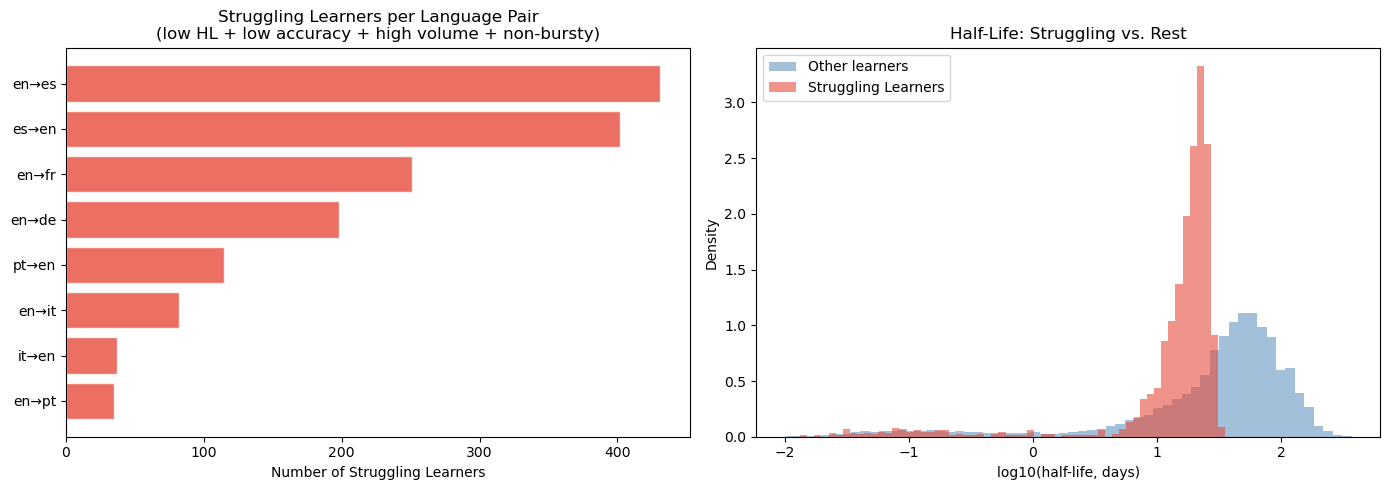


Saved:
  struggling_learners_all_pairs.csv — full review history
  struggling_learners_summary.csv   — one row per user


In [31]:
df_struggling_all, struggling_summary = extract_struggling_learners_all_pairs(
    df, save_csv=True)

In [32]:
df_struggling_all

,p_recall,timestamp,delta,user_id,learning_language_x,ui_language_x,lexeme_id,lexeme_string,history_seen,history_correct,...,pronoun_type,adj_declension,half_life_days,hl_percentile,pair_label,ui_language_y,learning_language_y,mean_accuracy,mean_delta_days,n_reviews
0,0.0,1362082541,28703,u:hSWF,pt,en,2d31fcb7e3781d53d073d32874dcb5f4,até/até<pr>,4,1,...,NaN,NaN,24.377594,0.317844,en→pt,en,pt,0.856565,2.325379,2263
1,0.0,1362082541,19513,u:hSWF,pt,en,2cedf47e09d69a11efbcdc6e6a59a3c6,falam/falar<vblex><pri><p3><pl>,2,2,...,NaN,NaN,24.377594,0.317844,en→pt,en,pt,0.856565,2.325379,2263
2,1.0,1362082541,77288,u:hSWF,pt,en,3b90f64dfa33918b221e0aabd249dc75,quando/quando<adv><itg>,5,3,...,NaN,NaN,24.377594,0.317844,en→pt,en,pt,0.856565,2.325379,2263
3,0.0,1362082541,27748,u:hSWF,pt,en,e44f3f20553dc6b97334e3c7cc574ced,ontem/ontem<adv>,8,5,...,NaN,NaN,24.377594,0.317844,en→pt,en,pt,0.856565,2.325379,2263
4,1.0,1362082541,23208,u:hSWF,pt,en,e07321c588bfe75e4d09b4628517218a,quero/querer<vblex><pri><p1><sg>,1,1,...,NaN,NaN,24.377594,0.317844,en→pt,en,pt,0.856565,2.325379,2263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702026,1.0,1363104890,90151,u:iZE_,de,en,9c71eca1890e52aa70c73f59b7d215ca,lehrer/lehrer<n><m><pl><nom>,5,3,...,NaN,NaN,24.806050,0.325723,en→de,en,de,0.890212,1.704941,349
702027,1.0,1363104890,90151,u:iZE_,de,en,de7cc64f2f73345c893d3de9bf662804,magst/mögen<vbmod><pri><p2><sg>,5,5,...,NaN,NaN,24.806050,0.325723,en→de,en,de,0.890212,1.704941,349
702028,1.0,1363104890,90151,u:iZE_,de,en,d2c8d82b57a02448138c274e578261de,restaurant/restaurant<n><nt><sg><dat>,7,5,...,NaN,NaN,24.806050,0.325723,en→de,en,de,0.890212,1.704941,349
702029,1.0,1363104890,543697,u:iZE_,de,en,5aa51924d40dbbb404d78bcfd3224157,tisch/tisch<n><m><sg><acc>,3,3,...,NaN,NaN,24.806050,0.325723,en→de,en,de,0.890212,1.704941,349


In [35]:
struggling_summary

,user_id,half_life,half_life_days,n_reviews,mean_p_recall,ui_language,learning_language,pair_label,mean_accuracy,mean_delta_days,is_struggling,hl_percentile
6,u:-t7,1.915901e+06,22.174776,311,0.718114,en,de,en→de,0.772201,4.814862,True,0.293046
9,u:1EF,7.214328e+05,8.349917,241,0.618949,en,de,en→de,0.793798,1.584357,True,0.128823
40,u:DRN,1.484653e+06,17.183486,136,0.762255,en,de,en→de,0.831830,4.369550,True,0.237746
59,u:IAx,2.115869e+06,24.489230,251,0.876494,en,de,en→de,0.884366,2.169517,True,0.322371
75,u:Ljt,2.189350e+06,25.339700,132,0.922276,en,de,en→de,0.868974,1.248840,True,0.332216
...,...,...,...,...,...,...,...,...,...,...,...,...
42485,u:ilkZ,1.755755e+06,20.321238,197,0.837563,pt,en,pt→en,0.872886,1.734851,True,0.323328
42544,u:ipIU,1.289121e+06,14.920383,586,0.779803,pt,en,pt→en,0.812110,1.340750,True,0.255275
42552,u:iprR,1.589850e+06,18.401039,184,0.763587,pt,en,pt→en,0.899540,3.279764,True,0.297771
42605,u:iyVh,1.718775e+06,19.893233,145,0.843153,pt,en,pt→en,0.887758,1.702662,True,0.317682


In [3]:
df_struggling_all = pd.read_csv('../datasets/struggling_learners_all_pairs.csv')
df_struggling_all.to_parquet('../datasets/struggling_learners_all_pairs.parquet')